#### Библиотеки

In [1]:
print("feeffefe")

feeffefe


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import json
import logging
import concurrent.futures
from pybit.unified_trading import HTTP
from pybit import exceptions
from collections import deque
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import pprint
import time
import torch
import torch.nn as nn
from scipy import stats
import seaborn as sns

In [2]:
key=""
secret=""

In [3]:
cl = HTTP(
    testnet=True,
    api_key=key,
    api_secret=secret,
    recv_window=60000
)

In [4]:
print(cl.upgrade_to_unified_trading_account())

{'retCode': 0, 'retMsg': 'SUCCESS', 'result': {'unifiedUpdateStatus': 'SUCCESS', 'unifiedUpdateMsg': None}, 'retExtInfo': {}, 'time': 1718437411370}


#### Данные

In [5]:
# Функция для загрузки данных из CSV и подготовки их для обучения
def load_data_from_csv(filename):
    df = pd.read_csv(filename)
    data_scaled = df.values
    return data_scaled

# Функция для создания последовательностей для входных данных модели
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Загрузка данных из CSV
data_scaled = load_data_from_csv('data_scaled.csv')

# Создание последовательностей для входных данных модели
look_back = 60  # Количество временных шагов для входной последовательности
X, y = create_dataset(data_scaled, look_back)

# Преобразование для LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

#### Старые данные

##### Данные для изначальной модели

In [2]:
symbol = 'INTC'
start_date = '2020-01-01'
end_date = '2023-07-05'

df_long = yf.download(symbol, start=start_date, end=end_date, interval='1d')

df_long = df_long.reset_index()
df_long['open'] = df_long['Open'].astype(float)
df_long['high'] = df_long['High'].astype(float)
df_long['low'] = df_long['Low'].astype(float)
df_long['close'] = df_long['Close'].astype(float)
df_long['adj_close'] = df_long['Adj Close'].astype(float)
df_long['volume'] = df_long['Volume'].astype(int)
df_long['date'] = df_long['Date'].astype(str)

df_long.dtypes

[*********************100%%**********************]  1 of 1 completed


Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
open                float64
high                float64
low                 float64
close               float64
adj_close           float64
volume                int32
date                 object
dtype: object

In [3]:
df_pre = df_long[['date','close']]
df_pre.head()

,date,close
0,2020-01-02,60.840000
1,2020-01-03,60.099998
2,2020-01-06,59.930000
3,2020-01-07,58.930000
4,2020-01-08,58.970001


##### Yahoo

In [6]:
import yfinance as yf

symbol = 'INTC'
start_date = '2020-01-01'
end_date = '2023-07-05'

# Получите исторические данные из Yahoo Finance
df_long = yf.download(symbol, start=start_date, end=end_date, interval='1d')

df_long = df_long.reset_index()
df_long['open'] = df_long['Open'].astype(float)
df_long['high'] = df_long['High'].astype(float)
df_long['low'] = df_long['Low'].astype(float)
df_long['close'] = df_long['Close'].astype(float)
df_long['adj_close'] = df_long['Adj Close'].astype(float)
df_long['volume'] = df_long['Volume'].astype(int)
df_long['date'] = df_long['Date'].astype(str)

df_long.dtypes

[*********************100%%**********************]  1 of 1 completed


Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
open                float64
high                float64
low                 float64
close               float64
adj_close           float64
volume                int32
date                 object
dtype: object

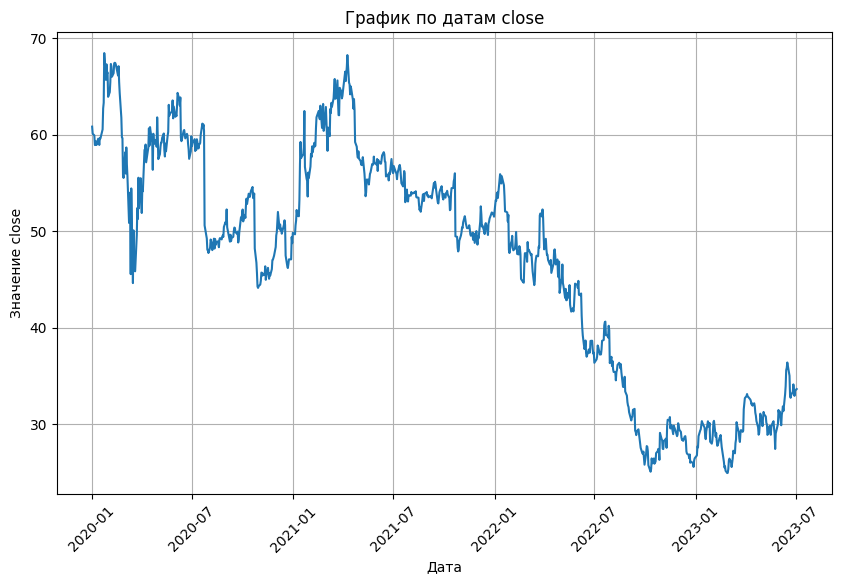

In [7]:
plt.figure(figsize=(10, 6))

# Постройте график
plt.plot(df_long['Date'], df_long['close'])
plt.title('График по датам close')
plt.xlabel('Дата')
plt.ylabel('Значение close')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

##### Препроцессинг

In [8]:
df_pre = df_long[['date','close']]
df_pre

,date,close
0,2020-01-02,60.840000
1,2020-01-03,60.099998
2,2020-01-06,59.930000
3,2020-01-07,58.930000
4,2020-01-08,58.970001
...,...,...
876,2023-06-27,34.099998
877,2023-06-28,33.570000
878,2023-06-29,32.910000
879,2023-06-30,33.439999


In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
datetime_object = str_to_datetime('1986-03-19')
datetime_object

In [ ]:
df_pre['date'] = df_pre['date'].apply(str_to_datetime)

<ipython-input-14-12d869df47f3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre['date'] = df_pre['date'].apply(str_to_datetime)


In [ ]:
df_pre = df_pre.set_index('date')
df_pre.head()

In [ ]:
def df_to_windowed_df(data, n=3):
    windowed_data = pd.DataFrame()
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data['close'].shift(i)
    windowed_data['Target'] = data['close']
    return windowed_data.dropna()

In [ ]:
windowed_df = df_to_windowed_df(df_pre)
windowed_df = windowed_df.reset_index()
windowed_df

,date,Target-3,Target-2,Target-1,Target
0,2020-01-07,60.840000,60.099998,59.930000,58.930000
1,2020-01-08,60.099998,59.930000,58.930000,58.970001
2,2020-01-09,59.930000,58.930000,58.970001,59.299999
3,2020-01-10,58.930000,58.970001,59.299999,58.939999
4,2020-01-13,58.970001,59.299999,58.939999,59.590000
...,...,...,...,...,...
873,2023-06-27,32.709999,33.000000,33.340000,34.099998
874,2023-06-28,33.000000,33.340000,34.099998,33.570000
875,2023-06-29,33.340000,34.099998,33.570000,32.910000
876,2023-06-30,34.099998,33.570000,32.910000,33.439999


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

In [ ]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

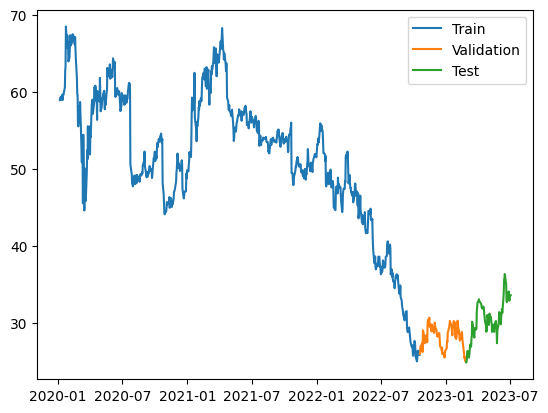

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

#### PRE-TRAINED LSTM

##### Конфиг-файлы

In [5]:
# config_data = """
# {
#   "input_dim": 1,
#   "hidden_dim": 64,
#   "num_layers": 5,
#   "output_dim": 1,
#   "num_epochs": 500
# }
# """

# # Запись данных в файл
# with open("/content/config.json", "w") as file:
#     file.write(config_data)

In [12]:
class LSTMStockPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMStockPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

##### Загрузка модели

In [13]:
config_path = 'lstm_model/config.json'
model_weights_path = 'lstm_model/pytorch_model.bin'

# Загрузка параметров из config.json
with open(config_path, 'r') as f:
    config = json.load(f)

# Создание экземпляра модели
lstm_model = LSTMStockPredictor(
    input_dim=config['input_dim'],
    hidden_dim=config['hidden_dim'],
    num_layers=config['num_layers'],
    output_dim=config['output_dim']
)

# Загрузка весов модели
lstm_model.load_state_dict(torch.load(model_weights_path))
lstm_model.eval()  # Перевод модели в режим оценки

LSTMStockPredictor(
  (lstm): LSTM(1, 64, num_layers=5, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

##### Загрузка данных

In [12]:
# # Функция для загрузки данных из CSV и подготовки их для обучения
# def load_data_from_csv(filename):
#     df = pd.read_csv(filename)
#     data_scaled = df.values
#     return data_scaled
# 
# # Функция для создания последовательностей для входных данных модели
# def create_dataset(dataset, look_back=1):
#     X, Y = [], []
#     for i in range(len(dataset) - look_back - 1):
#         a = dataset[i:(i + look_back), 0]
#         X.append(a)
#         Y.append(dataset[i + look_back, 0])
#     return np.array(X), np.array(Y)
# 
# # Загрузка данных из CSV
# data_scaled = load_data_from_csv('data_scaled.csv')
# 
# # Создание последовательностей для входных данных модели
# look_back = 60  # Количество временных шагов для входной последовательности
# X, y = create_dataset(data_scaled, look_back)
# 
# # Преобразование для LSTM
# X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [9]:
df_vis = pd.DataFrame(data_scaled, columns=['value'])
df_vis.describe()

,value
count,1000.000000
mean,0.454070
std,0.382862
min,0.000000
25%,0.159030
50%,0.307278
75%,0.962264
max,1.000000


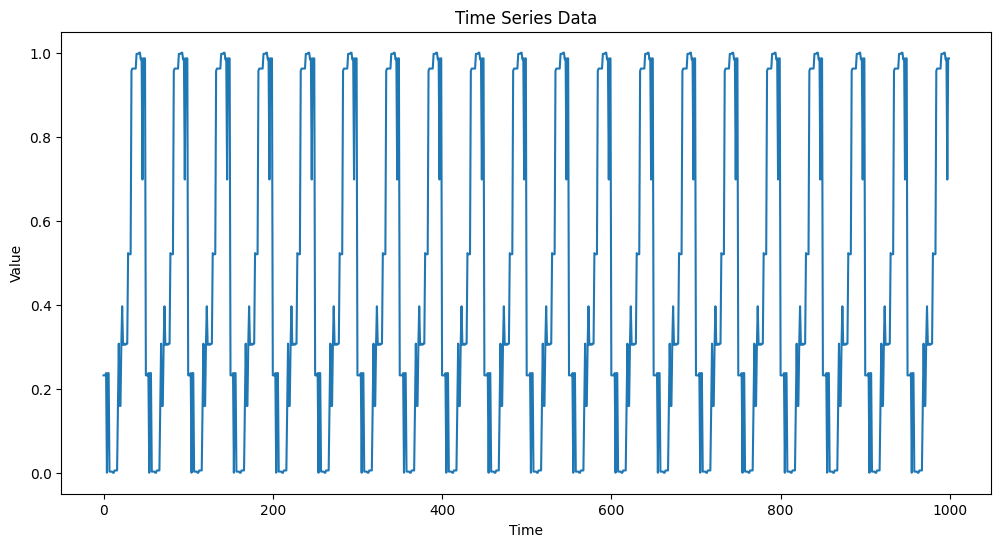

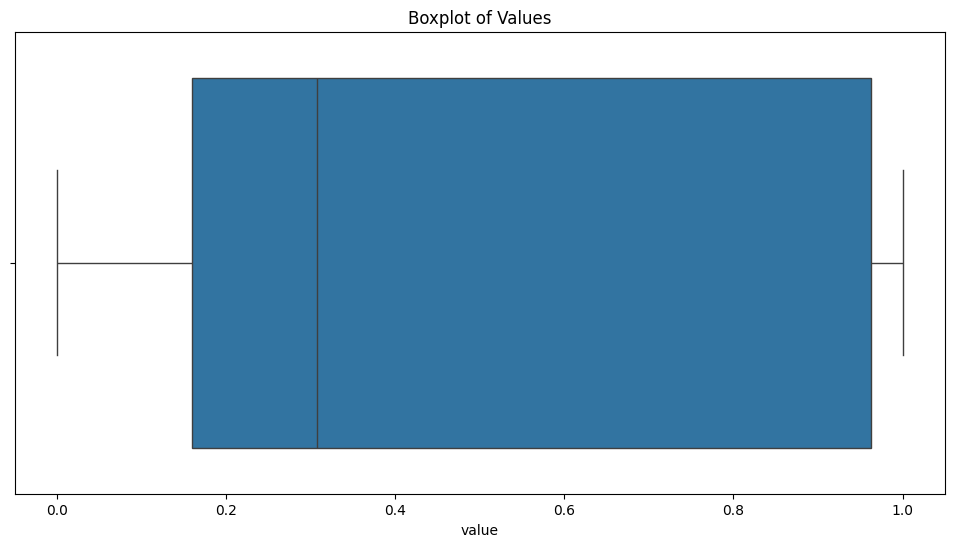

In [13]:
# График данных
plt.figure(figsize=(12, 6))
plt.plot(df_vis['value'])
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Boxplot для выявления выбросов
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_vis['value'])
plt.title('Boxplot of Values')
plt.show()

In [10]:
# Функция для получения данных и подготовки их для обучения
# def get_and_prepare_data(client, symbol, total_limit=100, batch_size=50):
#     all_prices = []
#     iterations = total_limit // batch_size
# 
#     for i in range(iterations):
#         r = client.get_public_trade_history(
#             category='linear',#"spot",
#             symbol=symbol,
#             limit=batch_size,
#         )
#         data = r['result']['list']
#         prices = [float(entry['price']) for entry in data]
#         all_prices.extend(prices)
# 
#     all_prices = np.array(all_prices).reshape(-1, 1)
# 
#     # Нормализация данных
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     data_scaled = scaler.fit_transform(all_prices)
# 
#     return data_scaled, scaler
# 
# # Функция для создания последовательностей для входных данных модели
# def create_dataset(dataset, look_back=1):
#     X, Y = [], []
#     for i in range(len(dataset) - look_back - 1):
#         a = dataset[i:(i + look_back), 0]
#         X.append(a)
#         Y.append(dataset[i + look_back, 0])
#     return np.array(X), np.array(Y)
# 
# # Загрузка данных
# data_scaled, scaler = get_and_prepare_data(cl, "ETHUSDT", total_limit=1000, batch_size=50)

In [11]:
# # Функция для сохранения data_scaled в csv
# def save_data_scaled_to_csv(data_scaled, filename='data_scaled.csv'):
#     df = pd.DataFrame(data_scaled, columns=['price'])
#     df.to_csv(filename, index=False)
# 
# # Загрузка данных
# data_scaled, scaler = get_and_prepare_data(cl, "ETHUSDT", total_limit=1000, batch_size=50)
# 
# # Сохранение данных
# save_data_scaled_to_csv(data_scaled)

In [8]:
data_scaled

array([[0.23180593],
       [0.23180593],
       [0.23180593],
       [0.23719677],
       [0.        ],
       [0.23719677],
       [0.23719677],
       [0.00269542],
       [0.00269542],
       [0.00269542],
       [0.00269542],
       [0.        ],
       [0.        ],
       [0.00539084],
       [0.00539084],
       [0.00539084],
       [0.00539084],
       [0.15902965],
       [0.30727763],
       [0.15902965],
       [0.15902965],
       [0.30458221],
       [0.39622642],
       [0.30458221],
       [0.30458221],
       [0.30727763],
       [0.30458221],
       [0.30727763],
       [0.30727763],
       [0.52291105],
       [0.52021563],
       [0.52021563],
       [0.52021563],
       [0.95687332],
       [0.96226415],
       [0.96226415],
       [0.96226415],
       [0.96226415],
       [0.96226415],
       [0.99730458],
       [0.99730458],
       [0.99730458],
       [1.        ],
       [1.        ],
       [0.98382749],
       [0.98652291],
       [0.69811321],
       [0.986

##### ДОобучение модели

In [161]:
# from pybit.unified_trading import HTTP
# from pybit import exceptions
# import pprint
# import concurrent.futures
# import time
# 
# cl = HTTP(
#     testnet=True,
#     api_key=key,
#     api_secret=secret,
#     recv_window=60000
# )

In [229]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Функция для получения данных и подготовки их для обучения
def get_and_prepare_data(client, symbol, limit=1000):
    r = client.get_public_trade_history(
        category="spot",
        symbol=symbol,
        limit=limit,
    )
    data = r['result']['list']
    prices = [float(entry['price']) for entry in data]
    prices = np.array(prices).reshape(-1, 1)

    # Нормализация данных
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(prices)

    return data_scaled, scaler

# Функция для создания последовательностей для входных данных модели
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Загрузка данных
data_scaled, scaler = get_and_prepare_data(cl, "ETHUSDT", limit=10000)

# Проверка, что данные загружены корректно
print("Scaled data:", data_scaled)

# Создание последовательностей для входных данных модели
look_back = 10#60  # Количество временных шагов для входной последовательности
if len(data_scaled) > look_back + 1:
    X, y = create_dataset(data_scaled, look_back)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Преобразование для LSTM
else:
    print(f"Not enough data to create sequences with look_back={look_back}")

# Конфигурация модели
config_path = 'lstm_model/config.json'
model_weights_path = 'lstm_model/pytorch_model.bin'

# Загрузка параметров из config.json
with open(config_path, 'r') as f:
    config = json.load(f)

# Обновленная модель с Dropout
class LSTMStockPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMStockPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Создание экземпляра модели
lstm_model = LSTMStockPredictor(
    input_dim=config['input_dim'],
    hidden_dim=config['hidden_dim'],
    num_layers=config['num_layers'],
    output_dim=config['output_dim']
)

# Загрузка весов модели
lstm_model.load_state_dict(torch.load(model_weights_path))
lstm_model.train()  # Перевод модели в режим обучения

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.0001)  # Уменьшение скорости обучения

# Определение количества эпох для дообучения
num_epochs = 50

# Процесс дообучения модели
if len(data_scaled) > look_back + 1:
    for epoch in range(num_epochs):
        for i in range(len(X)):
            inputs = torch.tensor(X[i:i+1], dtype=torch.float32)
            labels = torch.tensor(y[i:i+1], dtype=torch.float32)

            # Forward pass
            outputs = lstm_model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Сохранение дообученной модели
    torch.save(lstm_model.state_dict(), model_weights_path)
else:
    print("Not enough data to proceed with training")

Scaled data: [[0.60344828]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.62931034]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.        ]
 [0.56034483]
 [0.53448276]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.        ]
 [0.52586207]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.50862069]
 [1.        ]
 [1.        ]
 [0.45689655]
 [1.        ]
 [1.        ]
 [0.48275862]
 [0.48275862]
 [0.49137931]
 [1.        ]
 [0.45689655]]


C:\Users\Dimon\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Loss: 0.0354
Epoch [2/50], Loss: 0.0489
Epoch [3/50], Loss: 0.0646
Epoch [4/50], Loss: 0.1066
Epoch [5/50], Loss: 0.0805
Epoch [6/50], Loss: 0.0766
Epoch [7/50], Loss: 0.0753
Epoch [8/50], Loss: 0.0666
Epoch [9/50], Loss: 0.1134
Epoch [10/50], Loss: 0.0900
Epoch [11/50], Loss: 0.0834
Epoch [12/50], Loss: 0.0911
Epoch [13/50], Loss: 0.0575
Epoch [14/50], Loss: 0.1045
Epoch [15/50], Loss: 0.0767
Epoch [16/50], Loss: 0.0796
Epoch [17/50], Loss: 0.0810
Epoch [18/50], Loss: 0.0729
Epoch [19/50], Loss: 0.0978
Epoch [20/50], Loss: 0.0728
Epoch [21/50], Loss: 0.0741
Epoch [22/50], Loss: 0.1053
Epoch [23/50], Loss: 0.1288
Epoch [24/50], Loss: 0.0788
Epoch [25/50], Loss: 0.0813
Epoch [26/50], Loss: 0.0785
Epoch [27/50], Loss: 0.0896
Epoch [28/50], Loss: 0.0725
Epoch [29/50], Loss: 0.1116
Epoch [30/50], Loss: 0.0627
Epoch [31/50], Loss: 0.0660
Epoch [32/50], Loss: 0.0955
Epoch [33/50], Loss: 0.0961
Epoch [34/50], Loss: 0.0807
Epoch [35/50], Loss: 0.0767
Epoch [36/50], Loss: 0.1015
E

In [270]:
len(data_scaled)

60

##### Прогноз

In [19]:
# Прогноз
X_tensor = torch.tensor(X).float()
with torch.no_grad():
    predictions = lstm_model(X_tensor)
    predictions = predictions.numpy()

# Обратное масштабирование значений для получения истинных прогнозов
predictions_rescaled = scaler.inverse_transform(predictions)

In [20]:
df_stockdata = pd.DataFrame({
    'Real': data[-len(predictions_rescaled):].flatten(),
    'Predictions': predictions_rescaled.flatten()
})
df_stockdata['Deviations'] = df_stockdata['Real'] - df_stockdata['Predictions']
df_stockdata.head()

,Real,Predictions,Deviations
0,54.119999,52.585621,1.534378
1,51.880001,54.484596,-2.604595
2,54.349998,54.251961,0.098038
3,54.130001,52.165035,1.964966
4,58.430000,53.721729,4.708271


#### Визуализация рез-ов

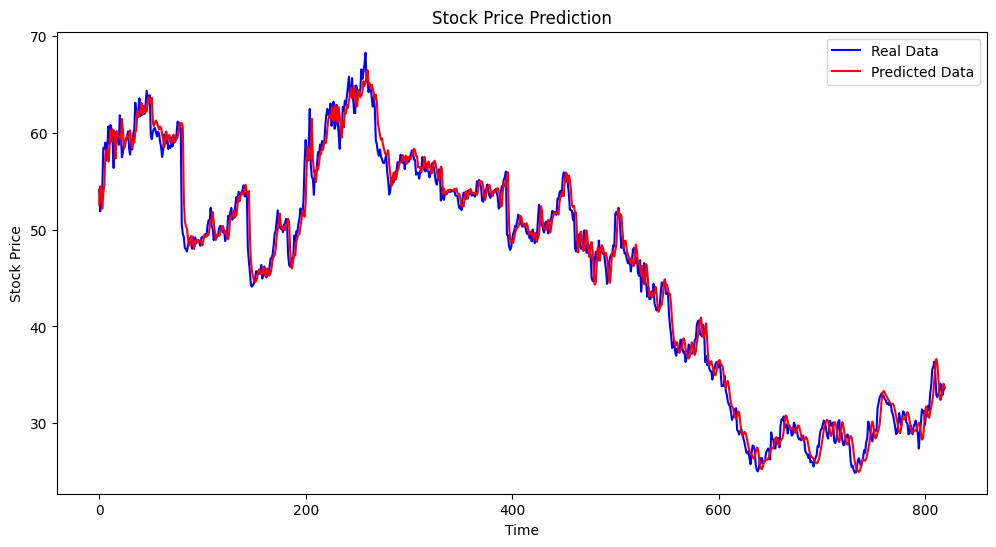

In [ ]:
# Отображение реальных данных и прогнозов на графике
plt.figure(figsize=(12, 6))
plt.plot(data[-len(predictions_rescaled):], label='Real Data', color='blue')  # Реальные данные
plt.plot(predictions_rescaled, label='Predicted Data', color='red')  # Прогнозируемые данные
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

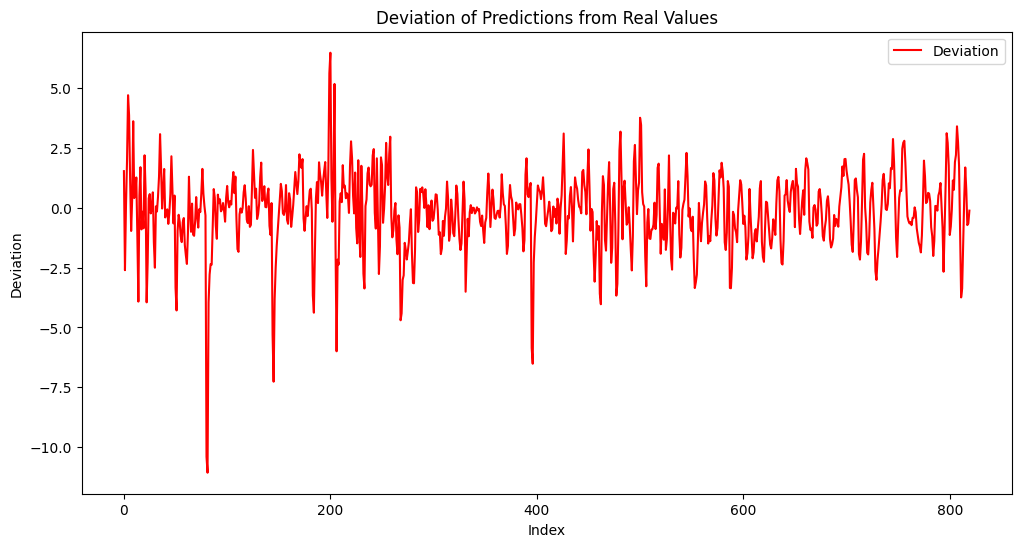

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_stockdata['Deviations'], label='Deviation', color='red')
plt.title('Deviation of Predictions from Real Values')
plt.xlabel('Index')
plt.ylabel('Deviation')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

def gini(actual, pred):
    assert len(actual) == len(pred)
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    total_losses = all[:, 0].sum()
    gini_sum = all[:, 0].cumsum().sum() / total_losses
    gini_sum -= (len(actual) + 1) / 2.
    return gini_sum / len(actual)

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

gini_score = gini_normalized(df_stockdata['Real'].values, df_stockdata['Predictions'].values)

# Вычисление метрик
mse = mean_squared_error(df_stockdata['Real'], df_stockdata['Predictions'])
mae = mean_absolute_error(df_stockdata['Real'], df_stockdata['Predictions'])
r2 = r2_score(df_stockdata['Real'], df_stockdata['Predictions'])
msle = mean_squared_log_error(df_stockdata['Real'], df_stockdata['Predictions'])

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')
print(f'Normalized Gini Coefficient: {gini_score}')
print(f'Mean Squared Logarithmic Error: {msle}')

MSE: 2.5020799871532957
MAE: 1.1235980243217654
R²: 0.9819544229048033
Normalized Gini Coefficient: 0.9882301047846379
Mean Squared Logarithmic Error: 0.0012164655096395507


Основные статистические показатели:
             Real  Predictions  Deviations
count  820.000000   820.000000  820.000000
mean    46.064085    46.230289   -0.166205
std     11.782303    11.799667    1.574000
min     24.900000    24.978630  -11.070339
25%     33.537499    34.010495   -0.945453
50%     49.179998    49.321712   -0.067842
75%     55.217500    55.470852    0.761596
max     68.260002    66.451729    6.484081

Персентили:
           Real  Predictions  Deviations
0.05  26.969999    27.072523   -2.650751
0.25  33.537499    34.010495   -0.945453
0.50  49.179998    49.321712   -0.067842
0.75  55.217500    55.470852    0.761596
0.95  62.460499    62.327251    2.047715

Мода для 'Real':
26.969999313354492


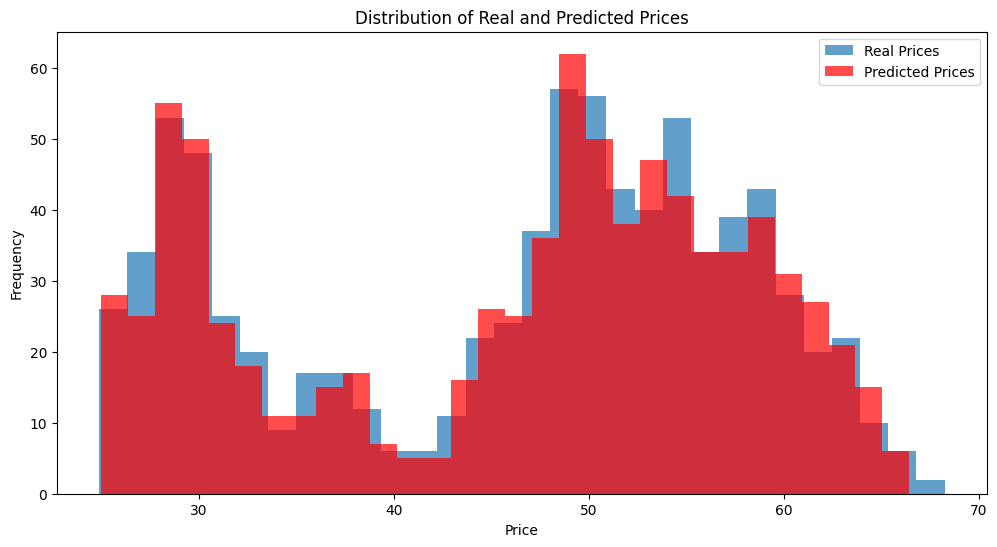

In [ ]:
# Статистический анализ
print("Основные статистические показатели:")
print(df_stockdata.describe())

# Персентили
print("\nПерсентили:")
print(df_stockdata.quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

# Мода
print("\nМода для 'Real':")
print(df_stockdata['Real'].mode().iloc[0])

plt.figure(figsize=(12, 6))
plt.hist(df_stockdata['Real'], bins=30, alpha=0.7, label='Real Prices')
plt.hist(df_stockdata['Predictions'], bins=30, alpha=0.7, label='Predicted Prices', color='red')
plt.title('Distribution of Real and Predicted Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### API песочницы тинька

#### ByBit

##### Libs

In [ ]:
# !pip install pybit

In [ ]:
# !pip install pycrypto

In [ ]:
# !pip install pycryptodome

In [29]:
import requests

# def get_external_ip():
#     response = requests.get('https://api.ipify.org?format=json')
#     if response.status_code == 200:
#         ip = response.json()['ip']
#         return print('fe')#ip
#     else:
#         raise Exception(f"Error fetching IP address: {response.status_code}")
# 
# # Пример использования
# try:
#     external_ip = get_external_ip()
#     print(f"My external IP address is: {external_ip}")
# except Exception as e:
#     print(f"An error occurred: {e}")

fe
My external IP address is: None


##### API

In [7]:
# key=""
# secret=""

In [8]:
# cl = HTTP(
#     testnet=True,
#     api_key=key,
#     api_secret=secret,
#     recv_window=60000
# )

In [9]:
# print(cl.upgrade_to_unified_trading_account())

{'retCode': 0, 'retMsg': 'SUCCESS', 'result': {'unifiedUpdateStatus': 'SUCCESS', 'unifiedUpdateMsg': None}, 'retExtInfo': {}, 'time': 1717792747230}


##### Methods

###### get_public_trade_history

In [160]:
r = cl.get_public_trade_history(
    category="spot",
    symbol="ETHUSDT",
    limit=3,
)
print(r)

{'retCode': 0, 'retMsg': 'OK', 'result': {'category': 'spot', 'list': [{'execId': '2110000000036894529', 'symbol': 'ETHUSDT', 'price': '3320.79', 'size': '0.02159', 'side': 'Sell', 'time': '1717334816594', 'isBlockTrade': False}, {'execId': '2110000000036894527', 'symbol': 'ETHUSDT', 'price': '3320.79', 'size': '0.0209', 'side': 'Buy', 'time': '1717334787476', 'isBlockTrade': False}, {'execId': '2110000000036894526', 'symbol': 'ETHUSDT', 'price': '3320.79', 'size': '0.02138', 'side': 'Sell', 'time': '1717334756873', 'isBlockTrade': False}]}, 'retExtInfo': {}, 'time': 1717334825930}


In [58]:
logging.basicConfig(format="%(asctime)s %(message)s", level=logging.DEBUG)
r = cl.get_orderbook(category="linear", symbol="SOLUSDT")
print(r)

2024-05-27 22:34:53,709 https://api-testnet.bybit.com:443 "GET /v5/market/orderbook?category=linear&symbol=SOLUSDT HTTP/1.1" 200 None


{'retCode': 0, 'retMsg': 'OK', 'result': {'s': 'SOLUSDT', 'b': [['170.2', '49150.5'], ['170.18', '41608'], ['170.16', '34476'], ['170.14', '23121'], ['170.12', '51913.3'], ['170.1', '45726.5'], ['170.08', '37842.5'], ['170.07', '0.1'], ['170.06', '47206.3'], ['170.04', '28271.4'], ['170.02', '62436.4'], ['170', '54452.3'], ['169.98', '31075.6'], ['169.95', '0.1'], ['169.94', '55469.9'], ['169.9', '54520.6'], ['169.87', '0.1'], ['169.86', '24715.3'], ['169.82', '42771.6'], ['169.8', '0.1'], ['169.78', '50651.9'], ['169.74', '47622.8'], ['169.72', '0.1'], ['169.7', '25646'], ['169.68', '0.1']], 'a': [['170.22', '44407.8'], ['170.25', '45523.4'], ['170.26', '30159.4'], ['170.29', '55221.5'], ['170.3', '36861.8'], ['170.33', '25859.6'], ['170.34', '52558.7'], ['170.37', '35448.2'], ['170.38', '28298.8'], ['170.41', '4732.6'], ['170.42', '27509.3'], ['170.45', '37132.7'], ['170.46', '23658.2'], ['170.49', '35484.6'], ['170.5', '48597.3'], ['170.53', '41552.1'], ['170.54', '57002.8'], ['170.

In [126]:
pprint.pprint(r.get('result'))

{'a': [['164.3', '36462.5'],
       ['164.33', '54245'],
       ['164.34', '34282.2'],
       ['164.37', '28423.2'],
       ['164.38', '41128.6'],
       ['164.41', '6125.8'],
       ['164.42', '46343.6'],
       ['164.45', '22867.4'],
       ['164.46', '24162'],
       ['164.49', '65211.4'],
       ['164.53', '37936.1'],
       ['164.57', '34122.3'],
       ['164.61', '36041.6'],
       ['164.62', '0.1'],
       ['164.65', '61345.6'],
       ['164.69', '57587.9'],
       ['164.73', '48552.8'],
       ['164.77', '37933.6'],
       ['164.81', '64567.3'],
       ['164.85', '48886.4'],
       ['165.04', '0.1'],
       ['165.07', '39.4'],
       ['165.34', '0.1'],
       ['165.38', '0.5'],
       ['165.39', '0.1']],
 'b': [['164.28', '22625.4'],
       ['164.26', '51828.5'],
       ['164.24', '54828.5'],
       ['164.22', '28327.7'],
       ['164.2', '34888.5'],
       ['164.18', '62350.5'],
       ['164.16', '59741.4'],
       ['164.14', '33538'],
       ['164.12', '23976.1'],
       ['16

In [80]:
# symb = cl.query_symbol()
# print(symb)

###### get_account_info

In [108]:
account_info = cl.get_account_info()
print(account_info)

2024-05-26 16:53:18,151 Starting new HTTPS connection (1): api-testnet.bybit.com:443
2024-05-26 16:53:18,548 https://api-testnet.bybit.com:443 "GET /v5/account/info HTTP/1.1" 200 218


{'retCode': 0, 'retMsg': 'OK', 'result': {'marginMode': 'REGULAR_MARGIN', 'updatedTime': '1716234395000', 'unifiedMarginStatus': 4, 'dcpStatus': 'OFF', 'timeWindow': 10, 'smpGroup': 0, 'isMasterTrader': False, 'spotHedgingStatus': 'OFF'}}


###### get_wallet_balance

In [59]:
balance = cl.get_wallet_balance(accountType='UNIFIED') #CONTRACT
pprint.pprint(balance)


2024-05-27 22:35:00,144 https://api-testnet.bybit.com:443 "GET /v5/account/wallet-balance?accountType=UNIFIED HTTP/1.1" 200 None


{'result': {'list': [{'accountIMRate': '0.0003',
                      'accountLTV': '0',
                      'accountMMRate': '0',
                      'accountType': 'UNIFIED',
                      'coin': [{'accruedInterest': '0',
                                'availableToBorrow': '',
                                'availableToWithdraw': '0.00011688',
                                'bonus': '0',
                                'borrowAmount': '0.000000000000000000',
                                'coin': 'ETH',
                                'collateralSwitch': False,
                                'cumRealisedPnl': '-0.00000312',
                                'equity': '0.00011688',
                                'locked': '0',
                                'marginCollateral': True,
                                'spotHedgingQty': '0',
                                'totalOrderIM': '0',
                                'totalPositionIM': '0',
                      

###### get_coin_info

In [121]:
coin_info = cl.get_coin_info(coin="SOL")
pprint.pprint(coin_info)

2024-05-26 16:57:31,694 https://api-testnet.bybit.com:443 "GET /v5/asset/coin/query-info?coin=SOL HTTP/1.1" 200 329


{'result': {'rows': [{'chains': [{'chain': 'SOL',
                                  'chainDeposit': '1',
                                  'chainType': 'Solana',
                                  'chainWithdraw': '',
                                  'confirmation': '1',
                                  'depositMin': '0',
                                  'minAccuracy': '8',
                                  'withdrawFee': '',
                                  'withdrawMin': '',
                                  'withdrawPercentageFee': ''}],
                      'coin': 'SOL',
                      'name': 'SOL',
                      'remainAmount': ''}]},
 'retCode': 0,
 'retExtInfo': {},
 'retMsg': '',
 'time': 1716731851523}


In [122]:
# размещение ордеров
try:
    r = cl.place_order(
            category="spot",
            symbol="ETHUSDT",#"SOLUSDT",
            side="BUY",
            orderType="Market",
            # qty=floor_price(avbl, 3),
            qty=1000,
            # marketUnit="quoteCoin",
    )
    pprint.pprint(r)
except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)

{'result': {'orderId': '1699483272113029632',
            'orderLinkId': '1699483272113029633'},
 'retCode': 0,
 'retExtInfo': {},
 'retMsg': 'OK',
 'time': 1717330193472}


In [29]:
# Настройка параметров отображения pandas
pd.set_option('display.max_columns', None)  # Показывать все столбцы
pd.set_option('display.width', None)  # Не ограничивать ширину вывода
pd.set_option('display.max_colwidth', None)  # Не ограничивать ширину столбцов
pd.options.display.expand_frame_repr = False

In [169]:
try:
    r = cl.get_order_history(category="spot")
    order_list = r['result']['list']
    filtered_orders = []

    for order in order_list:
        filtered_order = {
            'orderId': order['orderId'],
            'createdTime': order['createdTime'],
            'symbol': order['symbol'],
            'basePrice': order['basePrice'],
            'qty': order['qty'],
            'rejectReason': order['rejectReason'],
            'orderStatus': order['orderStatus'],
        }
        filtered_orders.append(filtered_order)
    df = pd.DataFrame(filtered_orders)
    print(df)

except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)

2024-05-26 18:30:03,573 https://api-testnet.bybit.com:443 "GET /v5/order/history?category=spot HTTP/1.1" 200 None


               orderId    createdTime   symbol basePrice         qty            rejectReason              orderStatus
0  1694509167735472640  1716737234022  ETHUSDT   3195.51  10.0000000  EC_CancelForNoFullFill  PartiallyFilledCanceled
1  1694507868642083328  1716737079159  SOLUSDT      25.5    10.00000  EC_ReachRiskPriceLimit                Cancelled
2  1694495152971973120  1716735563332  SOLUSDT      25.5    10.00000  EC_ReachRiskPriceLimit                Cancelled
3  1694490717554213376  1716735034590  SOLUSDT      25.5    10.00000  EC_ReachRiskPriceLimit                Cancelled
4  1694462315799511552  1716731648836  SOLUSDT      25.5    10.00000  EC_ReachRiskPriceLimit                Cancelled
5  1694462022961594880  1716731613928  SOLUSDT      25.5    10.00000  EC_ReachRiskPriceLimit                Cancelled


###### get_assets

In [18]:
def get_assets(cl : HTTP, coin):
    """
    Получаю остатки на аккаунте по конкретной монете
    :param cl:
    :param coin:
    :return:
    """
    r = cl.get_wallet_balance(accountType="UNIFIED")
    assets = {
        asset.get('coin') : float(asset.get('availableToWithdraw', '0.0'))
        for asset in r.get('result', {}).get('list', [])[0].get('coin', [])
    }
    return assets.get(coin, 0.0)

In [171]:
coin = "SOL"
avlb = get_assets(cl, coin)
print(coin+ ": " + str(avlb))

2024-05-26 18:30:52,518 https://api-testnet.bybit.com:443 "GET /v5/account/wallet-balance?accountType=UNIFIED HTTP/1.1" 200 None


SOL: 0.0


In [123]:
coin = "USDT"
avlb = get_assets(cl, coin)
print(coin+ ": " + str(avlb))

USDT: 3869.69488523


In [124]:
coin = "ETH"
avlb = get_assets(cl, coin)
print(coin+ ": " + str(avlb))

ETH: 0.3314631


###### get_instruments_info

In [126]:
# покупка - минимальный qty - minOrderAmt
# продажа - basePrecision знаков после зяпятой

try:
    r = cl.get_instruments_info(category='spot',symbol='ETHUSDT')
    pprint.pprint(r.get('result'))
    
except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)

{'category': 'spot',
 'list': [{'baseCoin': 'ETH',
           'innovation': '0',
           'lotSizeFilter': {'basePrecision': '0.00001',
                             'maxOrderAmt': '2000000',
                             'maxOrderQty': '2000000',
                             'minOrderAmt': '1',
                             'minOrderQty': '0.00001',
                             'quotePrecision': '0.0000001'},
           'marginTrading': 'both',
           'priceFilter': {'tickSize': '0.01'},
           'quoteCoin': 'USDT',
           'riskParameters': {'limitParameter': '0.07',
                              'marketParameter': '0.07'},
           'status': 'Trading',
           'symbol': 'ETHUSDT'}]}


In [179]:
def round_down(value, decimals):
    """
    функция для округления после запятой
    """
    factor = 1 / (10 ** decimals)
    return (value // factor) * factor

In [186]:
def float_trunc(f, prec):
    """
    Ещё один способ отбросить от float лишнее без округлений
    :param f:
    :param prec:
    :return:
    """
    l, r = f"{float(f):.12f}".split('.') # 12 дб достаточно для всех монет
    return  float(f'{l}.{r[:prec]}')

In [187]:
avlb = get_assets(cl, 'ETH')
print(round_down(avlb,5))

2024-05-26 18:56:22,090 https://api-testnet.bybit.com:443 "GET /v5/account/wallet-balance?accountType=UNIFIED HTTP/1.1" 200 None


0.0031100000000000004


In [193]:
# продажа
try:
    avlb = get_assets(cl, 'ETH')
    r = cl.place_order(
            category="spot",
            symbol="ETHUSDT",
            side="SELL",
            orderType="Market",
            qty=round_down(avlb, 3),
            # qty=10,
            # marketUnit="quoteCoin",
    )
    pprint.pprint(r)
    
except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)

2024-05-26 18:57:24,714 https://api-testnet.bybit.com:443 "GET /v5/account/wallet-balance?accountType=UNIFIED HTTP/1.1" 200 None
2024-05-26 18:57:25,331 https://api-testnet.bybit.com:443 "POST /v5/order/create HTTP/1.1" 200 143


{'result': {'orderId': '1694524360955789824',
            'orderLinkId': '1694524360964178432'},
 'retCode': 0,
 'retExtInfo': {},
 'retMsg': 'OK',
 'time': 1716739045197}


In [194]:
coin = "ETH"
avlb = get_assets(cl, coin)
print(coin+ ": " + str(avlb))

2024-05-26 18:58:08,771 https://api-testnet.bybit.com:443 "GET /v5/account/wallet-balance?accountType=UNIFIED HTTP/1.1" 200 None


ETH: 0.00011688


In [196]:
# цена тикера
SYMBOL="ETHUSDT"
price = float(cl.get_tickers(category="spot", symbol=SYMBOL).get('result').get('list')[0].get('ask1Price'))
print(price)

2024-05-26 19:34:48,546 Resetting dropped connection: api-testnet.bybit.com
2024-05-26 19:34:48,963 https://api-testnet.bybit.com:443 "GET /v5/market/tickers?category=spot&symbol=ETHUSDT HTTP/1.1" 200 428


3195.51


In [200]:
# цена тикера
SYMBOL="ETHUSDT"
price = float(cl.get_tickers(category="spot", symbol=SYMBOL).get('result').get('list')[0].get('ask1Price'))
print(price)

2024-05-26 21:37:12,347 Resetting dropped connection: api-testnet.bybit.com
2024-05-26 21:37:12,702 https://api-testnet.bybit.com:443 "GET /v5/market/tickers?category=spot&symbol=ETHUSDT HTTP/1.1" 200 427


3206.53


In [ ]:
from time import sleep

import requests
from pybit.unified_trading import WebSocket

def handle_message(m):
    print(m)

def handle_ticker(m):
    d = m.get('data', {})
    print(d['symbol'], d['lastPrice'], sep=":")

def subscribe_all_inst(ws : WebSocket):
    """
    Подписка на SPOT на все торгуемые к USDT пары,
    с разбивкой на 10 аргументов
    в ответ на комментарий
    https://www.youtube.com/watch?v=8SY-G0Hk64Y&lc=Ugxh1doXi5r-k4fEhK14AaABAg
    :param ws:
    :return:
    """
    url = "https://api.bybit.com/v5/market/instruments-info"
    l = requests.get(url, dict(category='spot')).json().get('result', {}).get('list', [])
    symbols = [ s['symbol'] for s in l if s['quoteCoin'] == 'USDT' and s['status'] == 'Trading']

    args_limit = 10
    for i in range(0, len(symbols), args_limit):
        ws.ticker_stream(symbol=(symbols[i:i + args_limit]), callback=handle_ticker)
        sleep(0.5)

def main():

    ws = WebSocket(
        testnet=False,
        channel_type="spot",
    )

    # subscribe_all_inst(ws)

    ws.ticker_stream(symbol=[
        "BTCUSDT",
        "ETHUSDT",
        "NEARUSDT",
        "BNBUSDT",
        "LTCUSDT",
        "ADAUSDT",
        "AVAXUSDT",
        "SUIUSDT",
        "IDUSDT",
        "BCHUSDT",
        "DOTUSDT",
        "MATICUSDT",
        "TONUSDT",
    ], callback=handle_ticker)

    while True: sleep(1)

if __name__ == '__main__':
    print('Hola, AzzraelCode YT Subs!')
    main()

### || ботов и сбор статистики

##### Main methods

In [8]:
symbol = "ETHUSDT"
coin = "ETH"
N = 500

In [9]:
def get_assets(cl : HTTP, coin):
    """
    Получаю остатки на аккаунте по конкретной монете
    :param cl:
    :param coin:
    :return:
    """
    r = cl.get_wallet_balance(accountType="UNIFIED")
    assets = {
        asset.get('coin') : float(asset.get('availableToWithdraw', '0.0'))
        for asset in r.get('result', {}).get('list', [])[0].get('coin', [])
    }
    return assets.get(coin, 0.0)

def round_down(value, decimals):
    """
    функция для округления после запятой
    """
    factor = 1 / (10 ** decimals)
    return (value // factor) * factor

In [10]:
def round_down(value, decimals):
    """
    функция для округления после запятой
    """
    factor = 1 / (10 ** decimals)
    return (value // factor) * factor

In [51]:
# coin = "ETH"
# avlb = get_assets(cl, coin)
# print(coin + ": " + str(avlb))

In [22]:
# продажа
try:
    avlb = get_assets(cl, "ETH")
    r = cl.place_order(
            category="spot",
            symbol="ETHUSDT",
            side="SELL",
            orderType="Market",
            qty=0.0001#round_down(avlb*0.1, 3),
            # qty=10,
            # marketUnit="quoteCoin",
    )
    pprint.pprint(r)
    
except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)
    

NameError: name 'exceptions' is not defined

In [ ]:
# покупка
try:
    r = cl.place_order(
                    category="spot",
                    symbol='ETHUSDT',
                    side="Buy",
                    orderType="Market",
                    qty=1000,  # Обновите количество согласно вашим нуждам
                )    
except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)

###### отладка действий

In [127]:
# покупка - минимальный qty - minOrderAmt
# продажа - basePrecision знаков после зяпятой
try:
    r = cl.get_instruments_info(category='spot',symbol='ETHUSDT')
    pprint.pprint(r.get('result'))
    
except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)

{'category': 'spot',
 'list': [{'baseCoin': 'ETH',
           'innovation': '0',
           'lotSizeFilter': {'basePrecision': '0.00001',
                             'maxOrderAmt': '2000000',
                             'maxOrderQty': '2000000',
                             'minOrderAmt': '1',
                             'minOrderQty': '0.00001',
                             'quotePrecision': '0.0000001'},
           'marginTrading': 'both',
           'priceFilter': {'tickSize': '0.01'},
           'quoteCoin': 'USDT',
           'riskParameters': {'limitParameter': '0.07',
                              'marketParameter': '0.07'},
           'status': 'Trading',
           'symbol': 'ETHUSDT'}]}


In [11]:
coin = "ETH"
avlb = get_assets(cl, coin)
print(coin + ": " + str(avlb))

ETH: 1.04031186


##### Оценка разных моделей 

###### LSTM

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Предположим, что LSTM модель уже загружена и готова к использованию
# lstm_model - это объект класса LSTMStockPredictor, который уже обучен

# Функция для создания последовательностей для входных данных модели
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Создание последовательностей для входных данных модели
look_back = 60  # Количество временных шагов для входной последовательности
X, y = create_dataset(data_scaled, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Преобразование для LSTM

# Прогноз на тех же данных, что использовались для обучения
lstm_model.eval()  # Перевод модели в режим оценки
X_tensor = torch.tensor(X, dtype=torch.float32)
with torch.no_grad():
    predictions = lstm_model(X_tensor).detach().numpy()

# Обратное масштабирование значений для получения истинных прогнозов
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data_scaled)  # Fit scaler to original data
predictions_rescaled = scaler.inverse_transform(predictions)
y_rescaled = scaler.inverse_transform(y.reshape(-1, 1))

# Метрики
mse = mean_squared_error(y_rescaled, predictions_rescaled)
mae = mean_absolute_error(y_rescaled, predictions_rescaled)
r2 = r2_score(y_rescaled, predictions_rescaled)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

# Создание DataFrame для визуализации
df_results = pd.DataFrame({
    'Real': y_rescaled.flatten(),
    'Predictions': predictions_rescaled.flatten()
})
df_results['Deviations'] = df_results['Real'] - df_results['Predictions']
df_results.head()

MSE: 0.0743130251773428
MAE: 0.22155996581329135
R²: 0.4927179709601849


,Real,Predictions,Deviations
0,0.002695,0.099697,-0.097002
1,0.000000,0.097626,-0.097626
2,0.000000,0.104033,-0.104033
3,0.005391,0.109947,-0.104556
4,0.005391,0.114125,-0.108734


###### Prophet

In [13]:
from prophet import Prophet

# Преобразование данных в формат, совместимый с Prophet
data = np.array(data_scaled).reshape(-1)
dates = pd.date_range(start='2022-01-01', periods=len(data), freq='D')  # Пример дат, необходимо подставить реальные даты
df_prophet = pd.DataFrame({'ds': dates, 'y': data})

# Инициализация и обучение модели Prophet
m = Prophet()
m.fit(df_prophet)

# Создание DataFrame для будущих предсказаний
future = m.make_future_dataframe(periods=0)  # Прогнозируем только для тренировочного периода
forecast = m.predict(future)

# Вывод результатов прогноза
forecast_actual = forecast[['ds', 'yhat']].set_index('ds')
df_prophet_actual = df_prophet.set_index('ds')
results = df_prophet_actual.join(forecast_actual, how='left')

# Метрики
mse = mean_squared_error(results['y'], results['yhat'])
mae = mean_absolute_error(results['y'], results['yhat'])
r2 = r2_score(results['y'], results['yhat'])

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

# Вывод результата
results.head()

Importing plotly failed. Interactive plots will not work.
20:54:20 - cmdstanpy - INFO - Chain [1] start processing
20:54:24 - cmdstanpy - INFO - Chain [1] done processing


MSE: 0.13603280520862684
MAE: 0.32500811222633497
R²: 0.07104863837522657


,y,yhat
ds,,
2022-01-01,0.231806,0.243397
2022-01-02,0.231806,0.262672
2022-01-03,0.231806,0.280703
2022-01-04,0.237197,0.302596
2022-01-05,0.000000,0.316450


###### ARIMA

In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Функция для создания последовательностей для входных данных модели
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Загрузка данных из CSV файла
data_scaled = pd.read_csv('data_scaled.csv').values

# Создание последовательностей для входных данных модели
look_back = 60  # Количество временных шагов для входной последовательности
X, y = create_dataset(data_scaled, look_back)

# Преобразование y в одномерный массив
y = y.flatten()

# Разделение данных на тренировочные и тестовые
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]

# Обучение модели ARIMA
model = ARIMA(train, order=(5, 1, 0))  # (p,d,q) параметры ARIMA
model_fit = model.fit()

# Прогнозирование
forecast = model_fit.forecast(steps=len(test))

# Обратное масштабирование значений для получения истинных прогнозов
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data_scaled)  # Fit scaler to original data
forecast_rescaled = scaler.inverse_transform(forecast.reshape(-1, 1))
test_rescaled = scaler.inverse_transform(test.reshape(-1, 1))

# Метрики
mse = mean_squared_error(test_rescaled, forecast_rescaled)
mae = mean_absolute_error(test_rescaled, forecast_rescaled)
r2 = r2_score(test_rescaled, forecast_rescaled)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

# Создание DataFrame для визуализации
df_results = pd.DataFrame({
    'Real': test_rescaled.flatten(),
    'Predictions': forecast_rescaled.flatten()
})
df_results['Deviations'] = df_results['Real'] - df_results['Predictions']
print(df_results.tail())

MSE: 0.4509436699364809
MAE: 0.5505126555829183
R²: -2.0775043259952954
         Real  Predictions  Deviations
183  1.000000    -0.087835    1.087835
184  0.983827    -0.087835    1.071663
185  0.986523    -0.087835    1.074358
186  0.698113    -0.087835    0.785948
187  0.986523    -0.087835    1.074358


###### Auto ARIMA

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-732.471, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1441.526, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-711.043, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=616.181, Time=0.42 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-730.778, Time=0.71 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-707.066, Time=3.97 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-775.475, Time=2.99 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-743.014, Time=1.25 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-779.326, Time=3.37 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-753.858, Time=1.06 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=-804.317, Time=1.24 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-806.919, Time=0.96 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-785.582, Time=0.46 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-744.151, Time=0.47 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept 

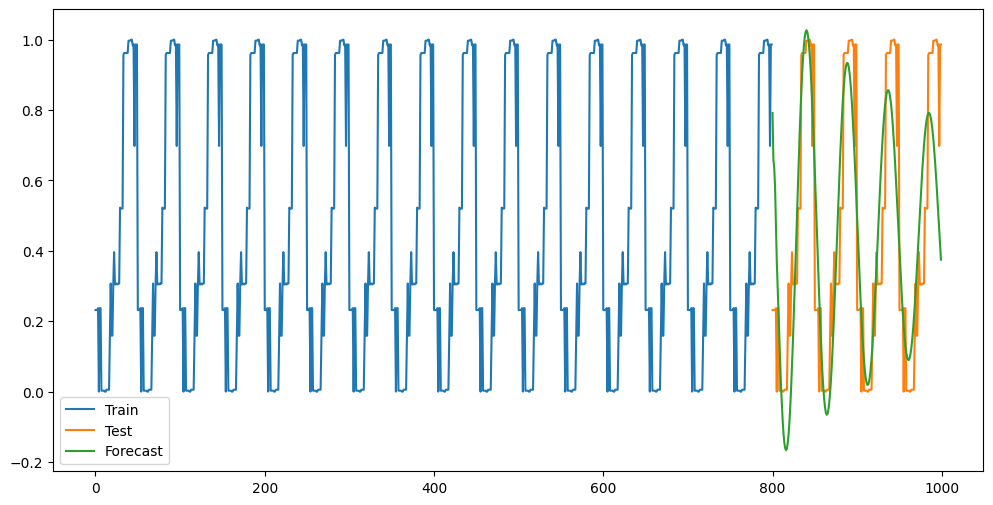

,Real,Predicted,Deviations
800,0.231806,0.791908,-0.560102
801,0.231806,0.658864,-0.427058
802,0.231806,0.636693,-0.404887
803,0.231806,0.580276,-0.348470
804,0.237197,0.471554,-0.234357


In [15]:
from pmdarima import auto_arima

# Загрузка данных из CSV и подготовка для ARIMA
data_scaled = pd.read_csv('data_scaled.csv').values.flatten()  # Загрузка и преобразование данных в 1-мерный массив
data = pd.Series(data_scaled)

# Разделение данных на тренировочные и тестовые
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Подбор лучших параметров для модели ARIMA
model = auto_arima(train, seasonal=False, trace=True)

# Обучение модели ARIMA с лучшими параметрами
model_fit = model.fit(train)

# Прогнозирование
forecast = model_fit.predict(n_periods=len(test))

# Вычисление метрик
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
r2 = r2_score(test, forecast)

# Вывод метрик
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.show()

# Сохранение результатов в DataFrame
results_df = pd.DataFrame({
    'Real': test.values,
    'Predicted': forecast,
    'Deviations': test.values - forecast
})
results_df.head()

In [18]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pytorch_lightning as pl

# Загружаем данные из CSV файла
data_scaled = pd.read_csv('data_scaled.csv').values.flatten()

# Преобразование данных в DataFrame
dates = pd.date_range(start='2022-01-01', periods=len(data_scaled), freq='D')
df = pd.DataFrame({'date': dates, 'value': data_scaled})

# Создание тренировочных и тестовых данных
look_back = 60
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

def create_sequences(data, look_back=60):
    sequences = []
    labels = []
    for i in range(len(data) - look_back):
        seq = data[i:i + look_back]
        label = data[i + look_back]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

train_sequences, train_labels = create_sequences(train['value'].values, look_back)
test_sequences, test_labels = create_sequences(test['value'].values, look_back)

train_sequences = train_sequences.reshape(train_sequences.shape[0], look_back, 1)
test_sequences = test_sequences.reshape(test_sequences.shape[0], look_back, 1)

train_dataset = TensorDataset(torch.tensor(train_sequences, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_sequences, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Модель TFT
class TFT(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, n_heads, n_layers):
        super(TFT, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_size, nhead=n_heads, dim_feedforward=hidden_size),
            num_layers=n_layers
        )
        self.fc = nn.Linear(input_size * look_back, output_size)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        sequences, labels = batch
        outputs = self(sequences)
        loss = nn.MSELoss()(outputs, labels)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

# Создание и обучение модели
model = TFT(input_size=1, hidden_size=16, output_size=1, n_heads=1, n_layers=1)
trainer = pl.Trainer(max_epochs=50, devices='auto', accelerator='auto')
trainer.fit(model, train_loader)

# Прогнозирование
model.eval()
predictions = []
actuals = []
for batch in test_loader:
    sequences, labels = batch
    with torch.no_grad():
        preds = model(sequences)
    predictions.extend(preds.numpy())
    actuals.extend(labels.numpy())

# Обратное масштабирование значений для получения истинных прогнозов
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data_scaled.reshape(-1, 1))
predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals_rescaled = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Метрики
mse = mean_squared_error(actuals_rescaled, predictions_rescaled)
mae = mean_absolute_error(actuals_rescaled, predictions_rescaled)
r2 = r2_score(actuals_rescaled, predictions_rescaled)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

# Создание DataFrame для визуализации
df_results = pd.DataFrame({
    'Real': actuals_rescaled.flatten(),
    'Predictions': predictions_rescaled.flatten()
})
df_results['Deviations'] = df_results['Real'] - df_results['Predictions']
print(df_results.tail())

C:\Users\Dimon\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | TransformerEncoder | 61    
1 | fc      | Linear             | 61    
-----------------------------------------------
122       Trainable params
0         Non-trainable params
122       Total params
0.000     Total estimated model params size (MB)
C:\Users\Dimon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_

Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\Dimon\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Dimon\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
`Trainer.fit` stopped: `max_epochs=50` reached.


MSE: 0.14880919456481934
MAE: 0.34348684549331665
R²: -0.0031740665435791016
         Real  Predictions  Deviations
135  0.983827     0.448208    0.535619
136  0.986523     0.448208    0.538315
137  0.698113     0.448208    0.249905
138  0.986523     0.448208    0.538315
139  0.986523     0.448208    0.538315


In [22]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pytorch_lightning as pl

# Загружаем данные из CSV файла
data_scaled = pd.read_csv('data_scaled.csv').values.flatten()

# Преобразование данных в DataFrame
dates = pd.date_range(start='2022-01-01', periods=len(data_scaled), freq='D')
df = pd.DataFrame({'date': dates, 'value': data_scaled})

# Создание тренировочных и тестовых данных
look_back = 60
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

def create_sequences(data, look_back=60):
    sequences = []
    labels = []
    for i in range(len(data) - look_back):
        seq = data[i:i + look_back]
        label = data[i + look_back]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

train_sequences, train_labels = create_sequences(train['value'].values, look_back)
test_sequences, test_labels = create_sequences(test['value'].values, look_back)

train_sequences = train_sequences.reshape(train_sequences.shape[0], look_back, 1)
test_sequences = test_sequences.reshape(test_sequences.shape[0], look_back, 1)

train_dataset = TensorDataset(torch.tensor(train_sequences, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_sequences, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Модель TFT
class TFT(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, n_heads, n_layers):
        super(TFT, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=n_heads, dim_feedforward=hidden_size * 4, dropout=0.1),
            num_layers=n_layers
        )
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size * look_back, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        sequences, labels = batch
        outputs = self(sequences)
        loss = nn.MSELoss()(outputs, labels)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.2)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'train_loss'}

# Создание и обучение модели
model = TFT(input_size=1, hidden_size=64, output_size=1, n_heads=4, n_layers=4)
trainer = pl.Trainer(max_epochs=300, devices='auto', accelerator='auto')
trainer.fit(model, train_loader)

# Прогнозирование
model.eval()
predictions = []
actuals = []
for batch in test_loader:
    sequences, labels = batch
    with torch.no_grad():
        preds = model(sequences)
    predictions.extend(preds.numpy())
    actuals.extend(labels.numpy())

# Обратное масштабирование значений для получения истинных прогнозов
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data_scaled.reshape(-1, 1))
predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals_rescaled = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Метрики
mse = mean_squared_error(actuals_rescaled, predictions_rescaled)
mae = mean_absolute_error(actuals_rescaled, predictions_rescaled)
r2 = r2_score(actuals_rescaled, predictions_rescaled)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

# Создание DataFrame для визуализации
df_results = pd.DataFrame({
    'Real': actuals_rescaled.flatten(),
    'Predictions': predictions_rescaled.flatten()
})
df_results['Deviations'] = df_results['Real'] - df_results['Predictions']
print(df_results.tail())

C:\Users\Dimon\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | TransformerEncoder | 199 K 
1 | fc1     | Linear             | 128   
2 | fc2     | Linear             | 3.8 K 
-----------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.816     Total estimated model params size (MB)
C:\Users\Dimon\AppData\Local\Programs\P

Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\Dimon\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Dimon\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
`Trainer.fit` stopped: `max_epochs=300` reached.


MSE: 0.1085311621427536
MAE: 0.27882763743400574
R²: 0.26835405826568604
         Real  Predictions  Deviations
135  0.983827     0.846246    0.137581
136  0.986523     0.838163    0.148360
137  0.698113     0.825889   -0.127776
138  0.986523     0.832963    0.153560
139  0.986523     0.832285    0.154238


##### Simple_bot

In [14]:
class SimpleTradingBot:
    def __init__(self, lstm_model, data, client, symbol, coin):
        self.lstm_model = lstm_model
        self.data = data
        self.client = client
        self.symbol = symbol
        self.coin = coin
        self.balance = get_assets(client, coin)  # Начальный баланс
        self.position = 0  # Начальная позиция
        self.transactions = []  # Список для хранения транзакций
        self.transaction_count = 0  # Счетчик операций
        self.last_buy_price = 0  # Последняя цена покупки

    def predict(self, X):
        X_torch = torch.tensor(X, dtype=torch.float32).unsqueeze(0)  # Добавление batch_size
        predictions = self.lstm_model(X_torch).detach().numpy()
        # print('Предсказания - ок')
        return predictions

    def trade(self):
        self.transaction_count += 1  # Увеличение счетчика операций
        i = self.transaction_count - 1  # Использование счетчика для индексации данных
        current_price = self.data[i][0]  # Получение значения из массива
        # print('fact: '+ str(current_price))
        prediction = self.predict(self.data[i:i+1])[0][0]
        # print('prediction: '+str(prediction))
        # print(f"Operation: {self.transaction_count}, Predicted: {prediction}, Current: {current_price}")  # Отладка
        if prediction > current_price:  # Если прогноз выше текущей цены
            self.buy(current_price, prediction)
        else:
            self.sell(current_price, prediction)

    def buy(self, price, prediction):
        print('method_buy')
        cnt = 5
        try:
            r = self.client.place_order(
                category="spot",
                symbol=self.symbol,
                side="Buy",
                orderType="Market",
                qty=cnt,  # Обновите количество согласно вашим нуждам
            )
            self.balance = get_assets(self.client, self.coin)  # Обновление баланса после транзакции
            profit_loss = float(price - self.last_buy_price)
            self.last_buy_price = price  # Сохранение последней цены покупки
            self.transactions.append({
                "type": "buy", 
                "price": price,
                "qty": cnt,
                "status": "ok", 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "orderId": str(r["result"]["orderId"]),
                "orderLinkId": str(r["result"]["orderLinkId"]),
                "profit_loss": profit_loss,  # При покупке прибыли/убытка нет
                "prediction": prediction
            })
            # pprint.pprint(r)
            self.position += 1
            # print(f'Купил по {price * 5:.8f}, баланс: {self.balance:.8f}, позиция: {self.position}')
        except exceptions.InvalidRequestError as e:
            self.transactions.append({
                "type": "buy", 
                "price": price, 
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print("ByBit Request Error", e.status_code, e.message, sep=" | ")
        except exceptions.FailedRequestError as e:
            self.transactions.append({
                "type": "buy", 
                "price": price, 
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
        except Exception as e:
            self.transactions.append({
                "type": "buy", 
                "price": price, 
                "status": "failed", 
                "reason": str(e), 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print(e)

    def sell(self, price, prediction):
        print('method_sell')
        cnt = 0.001
        try:
            r = self.client.place_order(
                category="spot",
                symbol=self.symbol,
                side="Sell",
                orderType="Market",
                qty=cnt#0.0001,
            )
            self.balance = get_assets(self.client, self.coin)  # Обновление баланса после транзакции
            profit_loss = float(price - self.last_buy_price)  # Расчет прибыли/убытка
            # print('profit_loss'+str(profit_loss))
            self.transactions.append({
                "type": "sell", 
                "price": price, 
                "qty": cnt,
                "status": "ok", 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "orderId": str(r["result"]["orderId"]),
                "orderLinkId": str(r["result"]["orderLinkId"]),
                "profit_loss": profit_loss,
                "prediction": prediction
            })
            # pprint.pprint(r)
            self.position -= 1
            # print(f'Продал по {price:.8f}, баланс: {self.balance:.8f}, позиция: {self.position}, profit/loss: {profit_loss:.8f}')
        except exceptions.InvalidRequestError as e:
            self.transactions.append({
                "type": "sell", 
                "price": price,
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print("ByBit Request Error", e.status_code, e.message, sep=" | ")
        except exceptions.FailedRequestError as e:
            self.transactions.append({
                "type": "sell", 
                "price": price,
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
        except Exception as e:
            self.transactions.append({
                "type": "sell", 
                "price": price, 
                "qty": 0,
                "status": "failed", 
                "reason": str(e), 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print(e)

def run_simple_bot(bot, n):
    for _ in range(n):
        bot.trade()
        # time.sleep(2)  # Задержка между транзакциями
        
# ------------------------------------------------------------------------------------------------
start_balance = get_assets(cl, coin)
# Пример использования
simple_bot = SimpleTradingBot(lstm_model, data_scaled, cl, symbol, coin)
run_simple_bot(simple_bot, N)

# Печать транзакций для отладки
# print(simple_bot.transactions)

# Создание DataFrame с транзакциями
simple_transactions_df = pd.DataFrame(simple_bot.transactions)
end_balance = get_assets(cl, coin)
# ------------------------------------------------------------------------------------------------

method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_sell
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_sell
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell


In [15]:
print(coin+ " start_balance: " + str(start_balance))
print(coin+ " end_balance: " + str(end_balance))

ETH start_balance: 1.57917934
ETH end_balance: 1.76046126


In [16]:
simple_transactions_df.head(500)

,type,price,qty,status,operation,balance,orderId,orderLinkId,profit_loss,prediction
0,buy,0.231806,5.000,ok,1,1.58057822 ETH,1708997166628078080,1708997166628078081,0.231806,0.356716
1,buy,0.231806,5.000,ok,2,1.58197710 ETH,1708997174051996160,1708997174051996161,0.000000,0.356716
2,buy,0.231806,5.000,ok,3,1.58337598 ETH,1708997178036584960,1708997178036584961,0.000000,0.356716
3,buy,0.237197,5.000,ok,4,1.58477486 ETH,1708997188513956352,1708997188513956353,0.005391,0.357654
4,buy,0.000000,5.000,ok,5,1.58617374 ETH,1708997198219575808,1708997198219575809,-0.237197,0.310924
...,...,...,...,...,...,...,...,...,...,...
495,sell,0.983827,0.001,ok,496,1.76446126 ETH,1708999161254511104,1708999161254511105,0.676550,0.431857
496,sell,0.986523,0.001,ok,497,1.76346126 ETH,1708999165205545472,1708999165205545473,0.679245,0.431993
497,sell,0.698113,0.001,ok,498,1.76246126 ETH,1708999169131414016,1708999169131414017,0.390836,0.413677
498,sell,0.986523,0.001,ok,499,1.76146126 ETH,1708999173099225600,1708999173099225601,0.679245,0.431993


In [22]:
# simple_transactions_df.to_csv('simple_transactions_new.csv', index=False)
# Дозапись в существующий CSV файл для Simple Bot
simple_transactions_df.to_csv('simple_transactions.csv', mode='a', header=False, index=False)

##### DQN_bot

###### DQN AutoArima

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

class DQNTradingBotARIMA:
    def __init__(self, data, state_size, action_size, client, symbol, coin):
        self.data = data
        self.state_size = state_size
        self.action_size = action_size
        self.client = client
        self.symbol = symbol
        self.coin = coin
        self.balance = get_assets(client, coin)  # Начальный баланс
        self.memory = deque(maxlen=2000)
        self.transactions = []  # Список для хранения транзакций
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.transaction_count = 0  # Счетчик операций
        self.last_buy_price = 0  # Последняя цена покупки

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, activation='relu', input_shape=(self.state_size,)))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def predict(self, X):
        model = ARIMA(X, order=(5, 1, 0))
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=1)
        return predictions

    def trade(self, n):
        start_time = time.time()  # Замер начала времени
        state = np.reshape(self.data[:self.state_size], [1, self.state_size])
        for time_step in range(n):
            self.transaction_count += 1
            action = self.act(state)  # Выбор действия на основе ε-жадной стратегии
            next_state = np.reshape(self.data[min(time_step + 1, len(self.data) - 1)], [1, self.state_size])  # Формирование следующего состояния
            reward = self.data[min(time_step + 1, len(self.data) - 1)] - self.data[time_step]  # Расчет награды как разница в цене
            done = time_step == n - 1  # Проверка на последний шаг
            self.remember(state, action, reward, next_state, done)  # Сохранение перехода в памяти
            state = next_state  # Переход к следующему состоянию

            if action == 0:  # Buy
                self.buy(self.data[time_step])
            else:  # Sell
                self.sell(self.data[time_step])

            if done:
                break

            # Уменьшение частоты вызова replay: только каждые 10 шагов
            if len(self.memory) > batch_size and time_step % 10 == 0:
                self.replay(batch_size)  # Обучение модели на минибатче

        end_time = time.time()  # Замер окончания времени
        duration = end_time - start_time  # Расчет длительности

    def buy(self, price):
        cnt = 5
        try:
            r = self.client.place_order(
                category="spot",
                symbol=self.symbol,
                side="Buy",
                orderType="Market",
                qty=cnt,  # Обновите количество согласно вашим нуждам
            )
            self.balance = get_assets(self.client, self.coin)  # Обновление баланса после транзакции
            self.last_buy_price = price  # Сохранение последней цены покупки
            self.transactions.append({
                "type": "buy", 
                "price": price, 
                "qty": cnt,
                "status": "ok", 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "orderId": str(r["result"]["orderId"]),
                "orderLinkId": str(r["result"]["orderLinkId"]),
                "profit_loss": 0  # При покупке прибыли/убытка нет
            })
        except exceptions.InvalidRequestError as e:
            self.transactions.append({
                "type": "buy", 
                "price": price, 
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0
            })
        except exceptions.FailedRequestError as e:
            self.transactions.append({
                "type": "buy", 
                "price": price, 
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0
            })
        except Exception as e:
            self.transactions.append({
                "type": "buy", 
                "price": price,
                "qty": 0,
                "status": "failed", 
                "reason": str(e), 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0
            })

    def sell(self, price):
        cnt = 0.001
        avlb = get_assets(self.client, self.coin)
        try:
            r = self.client.place_order(
                category="spot",
                symbol=self.symbol,
                side="Sell",
                orderType="Market",
                qty=cnt,
            )
            self.balance = get_assets(self.client, self.coin)  # Обновление баланса после транзакции
            profit_loss = (price - self.last_buy_price)  # Расчет прибыли/убытка
            self.transactions.append({
                "type": "sell", 
                "price": price, 
                "qty": cnt,
                "status": "ok", 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "orderId": str(r["result"]["orderId"]),
                "orderLinkId": str(r["result"]["orderLinkId"]),
                "profit_loss": profit_loss
            })
        except exceptions.InvalidRequestError as e:
            self.transactions.append({
                "type": "sell", 
                "price": price,
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0
            })
        except exceptions.FailedRequestError as e:
            self.transactions.append({
                "type": "sell", 
                "price": price,
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0
            })
        except Exception as e:
            self.transactions.append({
                "type": "sell", 
                "price": price, 
                "qty": 0,
                "status": "failed", 
                "reason": str(e), 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0
            })

# Пример использования
state_size = 1  # Количество входных параметров
action_size = 2  # Количество возможных действий (купить или продать)

start_balance = get_assets(cl, coin)

# Обучение и торговля DQN робота с ARIMA
dqn_bot_arima = DQNTradingBotARIMA(data_scaled.flatten(), state_size, action_size, cl, symbol, coin)
batch_size = 32  # Размер мини-пакета для обучения

# Запуск торгового робота DQN с N транзакциями
dqn_bot_arima.trade(N)

# Создание DataFrame с транзакциями
dqn_transactions_df_arima = pd.DataFrame(dqn_bot_arima.transactions)

# Конечный баланс
end_balance = get_assets(cl, coin)

C:\Users\Dimon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

###### DQN Common

In [25]:
# class DQNTradingBot:
#     def __init__(self, lstm_model, data, state_size, action_size, client, symbol, coin):
#         self.lstm_model = lstm_model
#         self.data = data
#         self.state_size = state_size
#         self.action_size = action_size
#         self.client = client
#         self.symbol = symbol
#         self.coin = coin
#         self.balance = get_assets(client, coin)  # Начальный баланс
#         self.memory = deque(maxlen=2000)
#         self.transactions = []  # Список для хранения транзакций
#         self.gamma = 0.95  # discount rate
#         self.epsilon = 1.0  # exploration rate
#         self.epsilon_min = 0.01
#         self.epsilon_decay = 0.995
#         self.learning_rate = 0.001
#         self.model = self._build_model()
#         self.transaction_count = 0  # Счетчик операций
#         self.last_buy_price = 0  # Последняя цена покупки
# 
#     def _build_model(self):
#         model = Sequential()
#         model.add(Dense(24, activation='relu', input_shape=(self.state_size,)))
#         model.add(Dense(24, activation='relu'))
#         model.add(Dense(self.action_size, activation='linear'))
#         model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
#         return model
# 
#     def remember(self, state, action, reward, next_state, done):
#         self.memory.append((state, action, reward, next_state, done))
# 
#     def act(self, state):
#         if np.random.rand() <= self.epsilon:
#             return random.randrange(self.action_size)
#         act_values = self.model.predict(state)
#         return np.argmax(act_values[0])
# 
#     def replay(self, batch_size):
#         minibatch = random.sample(self.memory, batch_size)
#         for state, action, reward, next_state, done in minibatch:
#             target = reward
#             if not done:
#                 target = (reward + self.gamma *
#                           np.amax(self.model.predict(next_state)[0]))
#             target_f = self.model.predict(state)
#             target_f[0][action] = target
#             self.model.fit(state, target_f, epochs=1, verbose=0)
#         if self.epsilon > self.epsilon_min:
#             self.epsilon *= self.epsilon_decay
# 
#     def predict(self, X):
#         X_torch = torch.tensor(X, dtype=torch.float32)
#         predictions = self.lstm_model(X_torch).detach().numpy()
#         return predictions
# 
#     def trade(self, n):
#         start_time = time.time()  # Замер начала времени
#         state = np.reshape(self.data[:self.state_size], [1, self.state_size])
#         for time_step in range(n):
#             self.transaction_count += 1
#             action = self.act(state)  # Выбор действия на основе ε-жадной стратегии
#             next_state = np.reshape(self.data[min(time_step + 1, len(self.data) - 1)], [1, self.state_size])  # Формирование следующего состояния
#             reward = self.data[min(time_step + 1, len(self.data) - 1)][0] - self.data[time_step][0]  # Расчет награды как разница в цене
#             done = time_step == n - 1  # Проверка на последний шаг
#             self.remember(state, action, reward, next_state, done)  # Сохранение перехода в памяти
#             state = next_state  # Переход к следующему состоянию
# 
#             if action == 0:  # Buy
#                 self.buy(self.data[time_step][0])
#             else:  # Sell
#                 self.sell(self.data[time_step][0])
# 
#             if done:
#                 # print(f'эпизод: {time_step}, награда: {reward}, e: {self.epsilon}')  # Вывод результатов по завершении эпизода
#                 break
# 
#             # Уменьшение частоты вызова replay: только каждые 10 шагов
#             if len(self.memory) > batch_size and time_step % 10 == 0:
#                 self.replay(batch_size)  # Обучение модели на минибатче
# 
#         end_time = time.time()  # Замер окончания времени
#         duration = end_time - start_time  # Расчет длительности
#         # print(f'Время выполнения метода trade: {duration:.2f} секунд или {duration/60:.2f} минут')
# 
#     def buy(self, price):
#         # print('method_buy')
#         cnt = 5
#         try:
#             r = self.client.place_order(
#                 category="spot",
#                 symbol=self.symbol,
#                 side="Buy",
#                 orderType="Market",
#                 qty=cnt,  # Обновите количество согласно вашим нуждам
#             )
#             self.balance = get_assets(self.client, self.coin)  # Обновление баланса после транзакции           
#             self.last_buy_price = price  # Сохранение последней цены покупки
#             self.transactions.append({
#                 "type": "buy", 
#                 "price": price, 
#                 "qty": cnt,
#                 "status": "ok", 
#                 "operation": self.transaction_count,
#                 "balance": f"{self.balance:.8f} {self.coin}",
#                 "orderId": str(r["result"]["orderId"]),
#                 "orderLinkId": str(r["result"]["orderLinkId"]),
#                 "profit_loss": 0  # При покупке прибыли/убытка нет
#             })
#             # pprint.pprint(r)
#         except exceptions.InvalidRequestError as e:
#             self.transactions.append({
#                 "type": "buy", 
#                 "price": price, 
#                 "qty": 0,
#                 "status": "failed", 
#                 "reason": e.message, 
#                 "operation": self.transaction_count,
#                 "balance": f"{self.balance:.8f} {self.coin}",
#                 "profit_loss": 0
#             })
#             # print("ByBit Request Error", e.status_code, e.message, sep=" | ")
#         except exceptions.FailedRequestError as e:
#             self.transactions.append({
#                 "type": "buy", 
#                 "price": price, 
#                 "qty": 0,
#                 "status": "failed", 
#                 "reason": e.message, 
#                 "operation": self.transaction_count,
#                 "balance": f"{self.balance:.8f} {self.coin}",
#                 "profit_loss": 0
#             })
#             # print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
#         except Exception as e:
#             self.transactions.append({
#                 "type": "buy", 
#                 "price": price,
#                 "qty": 0,
#                 "status": "failed", 
#                 "reason": str(e), 
#                 "operation": self.transaction_count,
#                 "balance": f"{self.balance:.8f} {self.coin}",
#                 "profit_loss": 0
#             })
#             # print(e)
# 
#     def sell(self, price):
#         # print('method_sell')
#         cnt = 0.001
#         avlb = get_assets(self.client, symbol)
#         try:
#             r = self.client.place_order(
#                 category="spot",
#                 symbol=self.symbol,
#                 side="Sell",
#                 orderType="Market",
#                 qty=cnt#0.0001,
#             )
#             self.balance = get_assets(self.client, self.coin)  # Обновление баланса после транзакции
#             profit_loss = (price - self.last_buy_price)  # Расчет прибыли/убытка
#             self.transactions.append({
#                 "type": "sell", 
#                 "price": price, 
#                 "qty": cnt,
#                 "status": "ok", 
#                 "operation": self.transaction_count,
#                 "balance": f"{self.balance:.8f} {self.coin}",
#                 "orderId": str(r["result"]["orderId"]),
#                 "orderLinkId": str(r["result"]["orderLinkId"]),
#                 "profit_loss": profit_loss
#             })
#             # pprint.pprint(r)
#         except exceptions.InvalidRequestError as e:
#             self.transactions.append({
#                 "type": "sell", 
#                 "price": price,
#                 "qty": 0,
#                 "status": "failed", 
#                 "reason": e.message, 
#                 "operation": self.transaction_count,
#                 "balance": f"{self.balance:.8f} {self.coin}",
#                 "profit_loss": 0
#             })
#             # print("ByBit Request Error", e.status_code, e.message, sep=" | ")
#         except exceptions.FailedRequestError as e:
#             self.transactions.append({
#                 "type": "sell", 
#                 "price": price,
#                 "qty": 0,
#                 "status": "failed", 
#                 "reason": e.message, 
#                 "operation": self.transaction_count,
#                 "balance": f"{self.balance:.8f} {self.coin}",
#                 "profit_loss": 0
#             })
#             # print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
#         except Exception as e:
#             self.transactions.append({
#                 "type": "sell", 
#                 "price": price, 
#                 "qty": 0,
#                 "status": "failed", 
#                 "reason": str(e), 
#                 "operation": self.transaction_count,
#                 "balance": f"{self.balance:.8f} {self.coin}",
#                 "profit_loss": 0
#             })
#             # print(e)
# 
# # ------------------------------------------------------------------------------------------------
# state_size = 1  # Количество входных параметров
# action_size = 2  # Количество возможных действий (купить или продать)
# 
# start_balance = get_assets(cl, coin)
# 
# # Обучение и торговля DQN робота
# dqn_bot = DQNTradingBot(lstm_model, data_scaled, state_size, action_size, cl, symbol, coin)
# batch_size = 32  # Размер мини-пакета для обучения
# 
# # Запуск торгового робота DQN с N транзакциями
# dqn_bot.trade(N)
# 
# # Печать транзакций для отладки
# # print(dqn_bot.transactions)
# 
# # Создание DataFrame с транзакциями
# dqn_transactions_df = pd.DataFrame(dqn_bot.transactions)
# 
# # Создание DataFrame с транзакциями
# end_balance = get_assets(cl, coin)
# # ------------------------------------------------------------------------------------------------

C:\Users\Dimon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [18]:
print(coin+ " start_balance: " + str(start_balance))
print(coin+ " end_balance: " + str(end_balance))

ETH start_balance: 1.76046126
ETH end_balance: 1.91295662


In [17]:
# dqn_transactions_df.head(500)
dqn_transactions_df_arima.head(500)

,type,price,qty,status,operation,balance,orderId,orderLinkId,profit_loss,reason
0,sell,0.231806,0.001,ok,1,1.58382019 ETH,1708419743020745216,1708419743020745217,0.231806,NaN
1,buy,0.231806,5.000,ok,2,1.58540860 ETH,1708419747030499840,1708419747030499841,0.000000,NaN
2,sell,0.231806,0.001,ok,3,1.58440860 ETH,1708419761903501824,1708419761903501825,0.000000,NaN
3,sell,0.237197,0.001,ok,4,1.58340860 ETH,1708419773228122624,1708419773228122625,0.005391,NaN
4,sell,0.000000,0.001,ok,5,1.58240860 ETH,1708419779788014080,1708419779788014081,-0.231806,NaN
...,...,...,...,...,...,...,...,...,...,...
495,sell,0.983827,0.001,ok,496,1.58237738 ETH,1708424420760224256,1708424420768612864,-0.016173,NaN
496,sell,0.986523,0.001,ok,497,1.58137738 ETH,1708424426850353664,1708424426850353665,-0.013477,NaN
497,sell,0.698113,0.001,ok,498,1.58037738 ETH,1708424432957260288,1708424432957260289,-0.301887,NaN
498,buy,0.986523,5.000,ok,499,1.58196579 ETH,1708424437008957952,1708424437008957953,0.000000,NaN


In [21]:
# dqn_transactions_df_arima.to_csv('dqn_transactions_new.csv', index=False)
# dqn_transactions_df.to_csv('simple_transactions.csv', mode='a', header=False, index=False)

# dqn_transactions_df_arima.to_csv('dqn_transactions_arima.csv', index=False)
dqn_transactions_df_arima.to_csv('dqn_transactions_arima.csv', mode='a', header=False, index=False)

##### __Debug__

In [ ]:
# При покупке: profit_loss = 0 (при покупке прибыли/убытка нет, он возникает при продаже)
# При продаже: profit_loss = (Цена продажи - Цена покупки) * Количество
# last_buy_price = price

profit_loss = (price - self.last_buy_price) * 0.0001

In [86]:
import torch

# ----------------------------------------------------------------------------------------------------------------------------------------
class LSTMStockPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMStockPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
# ----------------------------------------------------------------------------------------------------------------------------------------

# Функция для нормализации входного значения
def normalize_value(value, scaler):
    value = np.array([[value]])
    return scaler.transform(value)[0][0]

# Функция для денормализации предсказанного значения
def denormalize_value(value, scaler):
    value = np.array([[value]])
    return scaler.inverse_transform(value)[0][0]

# Функция для получения предсказания модели
def get_prediction(model, scaler, input_value):
    normalized_value = normalize_value(input_value, scaler)
    input_tensor = torch.tensor([[[normalized_value]]], dtype=torch.float32)  # Добавление батча и временной оси
    model.eval()
    with torch.no_grad():
        prediction = model(input_tensor).item()
    denormalized_prediction = denormalize_value(prediction, scaler)
    return denormalized_prediction

# Пример использования
input_value = float(input("Введите значение: "))
predicted_value = get_prediction(lstm_model, scaler, input_value)
print(f"Predicted: {predicted_value:.2f}")

Predicted: 37.41


In [41]:
import numpy as np

# Рассчитываем средний прирост баланса на сделку
def average_balance_increase(transactions_df, start_balance):
    end_balance = float(transactions_df['balance'].iloc[-1].split()[0])
    num_transactions = len(transactions_df)
    return (end_balance - start_balance) / num_transactions

# Рассчитываем стандартное отклонение прибыли/убытка
def profit_loss_std(transactions_df):
    profit_losses = transactions_df['profit_loss'].astype(float)
    return profit_losses.std()

# Рассчитываем процент успешных сделок
def success_rate(transactions_df):
    successful_trades = transactions_df[transactions_df['profit_loss'].astype(float) > 0]
    return len(successful_trades) / len(transactions_df)

# Рассчитываем Шарп-коэффициент
def sharpe_ratio(transactions_df, risk_free_rate=0.01):
    profit_losses = transactions_df['profit_loss'].astype(float)
    mean_profit_loss = profit_losses.mean()
    std_profit_loss = profit_losses.std()
    return (mean_profit_loss - risk_free_rate) / std_profit_loss

# Начальный баланс для Simple Bot
simple_start_balance = float(simple_transactions_df['balance'].iloc[0].split()[0])

# Начальный баланс для DQN Bot
dqn_start_balance = float(dqn_transactions_df['balance'].iloc[0].split()[0])

# Вычисление метрик для Simple Bot
simple_avg_increase = average_balance_increase(simple_transactions_df, simple_start_balance)
simple_std = profit_loss_std(simple_transactions_df)
simple_success_rate = success_rate(simple_transactions_df)
simple_sharpe = sharpe_ratio(simple_transactions_df)

# Вычисление метрик для DQN Bot
dqn_avg_increase = average_balance_increase(dqn_transactions_df, dqn_start_balance)
dqn_std = profit_loss_std(dqn_transactions_df)
dqn_success_rate = success_rate(dqn_transactions_df)
dqn_sharpe = sharpe_ratio(dqn_transactions_df)

print("Simple Bot Metrics:")
print(f"Average Balance Increase per Trade: {simple_avg_increase:.4f}")
print(f"Profit/Loss Standard Deviation: {simple_std:.4f}")
print(f"Success Rate: {simple_success_rate:.2%}")
print(f"Sharpe Ratio: {simple_sharpe:.4f}")

print("\nDQN Bot Metrics:")
print(f"Average Balance Increase per Trade: {dqn_avg_increase:.4f}")
print(f"Profit/Loss Standard Deviation: {dqn_std:.4f}")
print(f"Success Rate: {dqn_success_rate:.2%}")
print(f"Sharpe Ratio: {dqn_sharpe:.4f}")

Simple Bot Metrics:
Average Balance Increase per Trade: -0.0003
Profit/Loss Standard Deviation: 0.3086
Success Rate: 76.00%
Sharpe Ratio: 1.3968

DQN Bot Metrics:
Average Balance Increase per Trade: 0.0005
Profit/Loss Standard Deviation: 0.1901
Success Rate: 7.80%
Sharpe Ratio: 0.0348


In [42]:
from scipy import stats

# Начальный баланс
simple_start_balance = float(simple_transactions_df['balance'].iloc[0].split()[0])
dqn_start_balance = float(dqn_transactions_df['balance'].iloc[0].split()[0])

# Конечный баланс
simple_end_balance = float(simple_transactions_df['balance'].iloc[-1].split()[0])
dqn_end_balance = float(dqn_transactions_df['balance'].iloc[-1].split()[0])

# Средний прирост баланса на сделку
simple_avg_increase = average_balance_increase(simple_transactions_df, simple_start_balance)
dqn_avg_increase = average_balance_increase(dqn_transactions_df, dqn_start_balance)

# T-тест для сравнения среднего прироста баланса на сделку
t_stat, p_value = stats.ttest_ind(
    simple_transactions_df['profit_loss'].astype(float), 
    dqn_transactions_df['profit_loss'].astype(float)
)

print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

if p_value < 0.05:
    print("Существует статистически значимое различие между двумя ботами.")
else:
    print("Нет статистически значимого различия между двумя ботами.")


T-Statistic: 26.1842
P-Value: 0.0000
Существует статистически значимое различие между двумя ботами.


### AB-test

In [23]:
# dqn_transactions_df_ = pd.read_csv(f'dqn_transactions_arima.csv') 
# simple_transactions_df_ = pd.read_csv(f'simple_transactions.csv')

dqn_transactions_df_ = pd.read_csv(f'dqn_transactions_new.csv') 
simple_transactions_df_ = pd.read_csv(f'simple_transactions_new.csv')

In [15]:
dqn_transactions_df_.head()

,type,price,qty,status,operation,balance,orderId,orderLinkId,profit_loss,reason
0,buy,0.231806,5.000,ok,1,1.57609997 ETH,1.705515e+18,1.705515e+18,0.0,NaN
1,buy,0.231806,5.000,ok,2,1.57772834 ETH,1.705515e+18,1.705515e+18,0.0,NaN
2,sell,0.231806,0.001,ok,3,1.57672834 ETH,1.705515e+18,1.705515e+18,0.0,NaN
3,buy,0.237197,5.000,ok,4,1.57835671 ETH,1.705515e+18,1.705515e+18,0.0,NaN
4,buy,0.000000,5.000,ok,5,1.57998508 ETH,1.705515e+18,1.705515e+18,0.0,NaN


In [16]:
simple_transactions_df_.tail()

,type,price,qty,status,operation,balance,orderId,orderLinkId,profit_loss,prediction,reason
1495,sell,0.983827,0.001,ok,496,1.57492776 ETH,1.705541e+18,1.705541e+18,0.981132,0.431857,NaN
1496,sell,0.986523,0.001,ok,497,1.57392776 ETH,1.705541e+18,1.705541e+18,0.983827,0.431993,NaN
1497,sell,0.698113,0.001,ok,498,1.57292776 ETH,1.705541e+18,1.705541e+18,0.695418,0.413677,NaN
1498,sell,0.986523,0.001,ok,499,1.57192776 ETH,1.705541e+18,1.705541e+18,0.983827,0.431993,NaN
1499,sell,0.986523,0.001,ok,500,1.57092776 ETH,1.705541e+18,1.705541e+18,0.983827,0.431993,NaN


In [25]:
simple_transactions_df_['profit_loss'].describe()

count    1500.000000
mean        0.294252
std         0.379062
min        -0.237197
25%         0.000000
50%         0.000000
75%         0.657682
max         1.000000
Name: profit_loss, dtype: float64

In [26]:
dqn_transactions_df_['profit_loss'].describe()

count    1500.000000
mean        0.003296
std         0.189698
min        -0.986523
25%         0.000000
50%         0.000000
75%         0.002695
max         0.654987
Name: profit_loss, dtype: float64

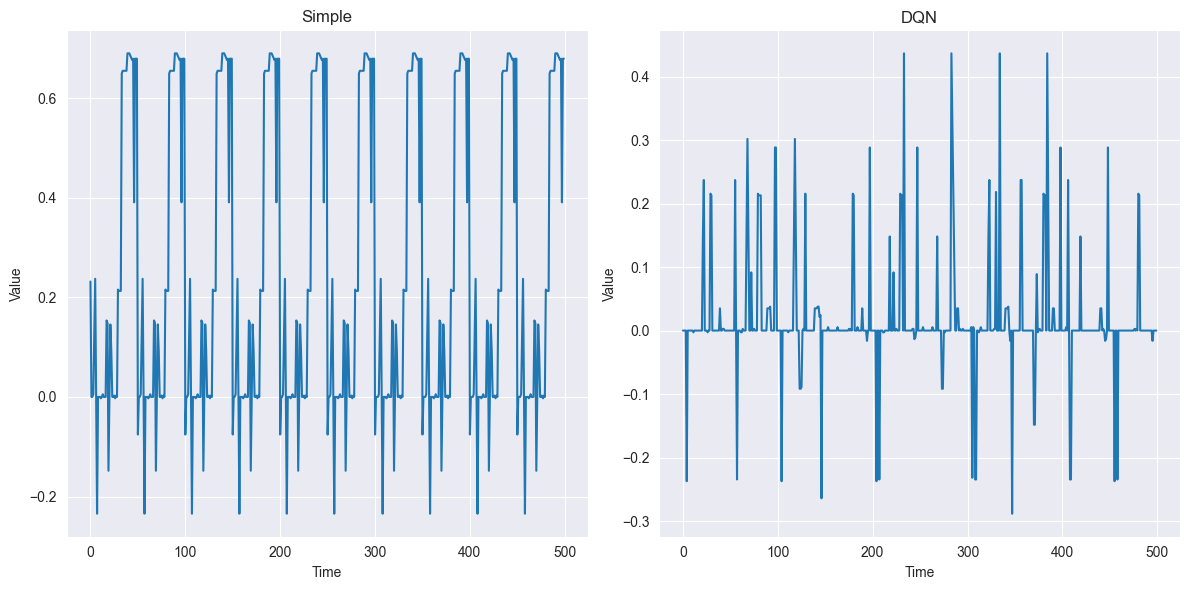

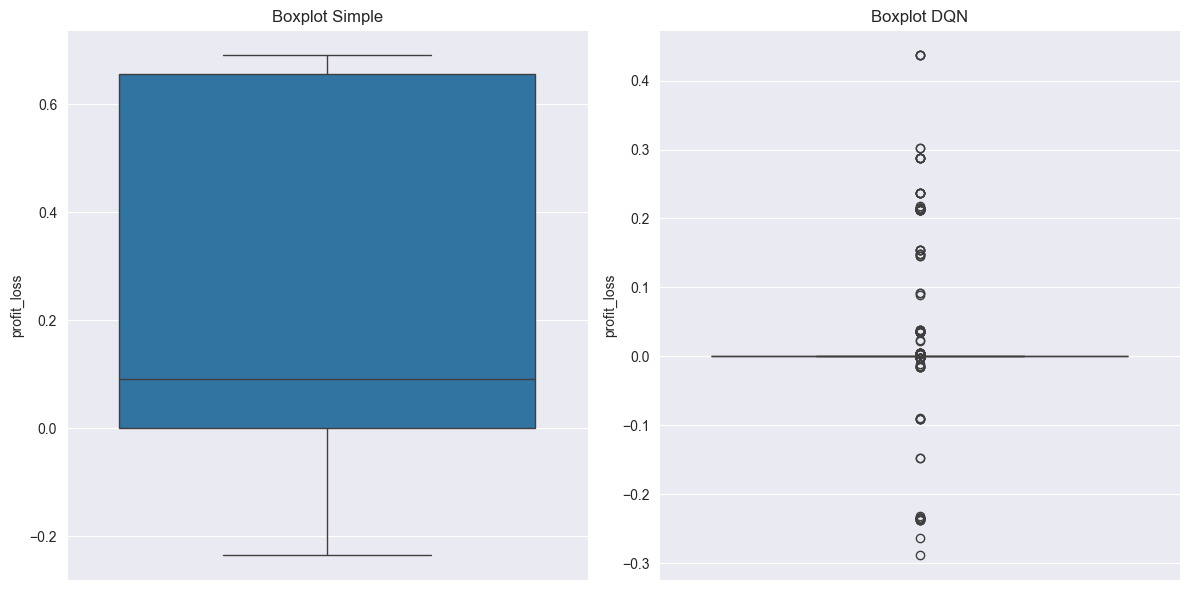

In [24]:
q_low_dqn = dqn_transactions_df_['profit_loss'].quantile(0.005)
q_high_dqn = dqn_transactions_df_['profit_loss'].quantile(0.995)
filtered_dqn_df = dqn_transactions_df_[(dqn_transactions_df_['profit_loss'] > q_low_dqn) & (dqn_transactions_df_['profit_loss'] < q_high_dqn)]

q_low_simple = simple_transactions_df_['profit_loss'].quantile(0.005)
q_high_simple = simple_transactions_df_['profit_loss'].quantile(0.995)
filtered_simple_df = simple_transactions_df_[(simple_transactions_df_['profit_loss'] > q_low_simple) & (simple_transactions_df_['profit_loss'] < q_high_simple)]


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(filtered_simple_df['profit_loss'])
plt.title('Simple')
plt.xlabel('Time')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(filtered_dqn_df['profit_loss'])
plt.title('DQN')
plt.xlabel('Time')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

# Boxplot для выявления выбросов
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(filtered_simple_df['profit_loss'])
plt.title('Boxplot Simple')

plt.subplot(1, 2, 2)
sns.boxplot(filtered_dqn_df['profit_loss'])
plt.title('Boxplot DQN')

plt.tight_layout()
plt.show()

In [28]:
from scipy.stats import levene

# Проведение теста Левена
# stat, p_value = levene(simple_transactions_df_['profit_loss'], dqn_transactions_df_['profit_loss'])
stat, p_value = levene(filtered_simple_df['profit_loss'], filtered_dqn_df['profit_loss'])

print(f'Levene’s test statistic: {stat:.4f}')
print(f'P-value: {p_value:.4f}')

# Интерпретация результатов
alpha = 0.05
if p_value > alpha:
    print('Обе выборки имеют равные дисперсии (не отклоняем нулевую гипотезу)')
else:
    print('Выборки имеют разные дисперсии (отклоняем нулевую гипотезу)')

Levene’s test statistic: 652.2550
P-value: 0.0000
Выборки имеют разные дисперсии (отклоняем нулевую гипотезу)


In [35]:
from sklearn.preprocessing import StandardScaler

# Нормализация данных
scaler = StandardScaler()

simple_normalized = scaler.fit_transform(simple_transactions_df_['profit_loss'].values.reshape(-1, 1)).flatten()
dqn_normalized = scaler.fit_transform(dqn_transactions_df_['profit_loss'].values.reshape(-1, 1)).flatten()

# Проведение теста Левена на нормализованных данных
stat, p_value = levene(simple_normalized, dqn_normalized)

print(f'Levene’s test statistic: {stat:.4f}')
print(f'P-value: {p_value:.4f}')

# Интерпретация результатов
alpha = 0.05
if p_value > alpha:
    print('Обе выборки имеют равные дисперсии (не отклоняем нулевую гипотезу)')
else:
    print('Выборки имеют разные дисперсии (отклоняем нулевую гипотезу)')


Levene’s test statistic: 159.4943
P-value: 0.0000
Выборки имеют разные дисперсии (отклоняем нулевую гипотезу)


In [32]:
from scipy.stats import ttest_ind

stat, p_value = ttest_ind(simple_normalized, dqn_normalized, equal_var=False)

print(f"Welch's t-test statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Интерпретация результатов
alpha = 0.05
if p_value > alpha:
    print('Средние значения двух групп не различаются значимо (не отклоняем нулевую гипотезу)')
else:
    print('Средние значения двух групп различаются значимо (отклоняем нулевую гипотезу)')

Welch's t-test statistic: -0.0000
P-value: 1.0000
Средние значения двух групп не различаются значимо (не отклоняем нулевую гипотезу)


In [33]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(simple_normalized, dqn_normalized)

print(f"Mann-Whitney U test statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Интерпретация результатов
alpha = 0.05
if p_value > alpha:
    print('Средние значения двух групп не различаются значимо (не отклоняем нулевую гипотезу)')
else:
    print('Средние значения двух групп различаются значимо (отклоняем нулевую гипотезу)')

Mann-Whitney U test statistic: 904841.0000
P-value: 0.0000
Средние значения двух групп различаются значимо (отклоняем нулевую гипотезу)


In [36]:
# Подсчет успешных транзакций (status == 'ok')
dqn_successful_trades = dqn_transactions_df_[dqn_transactions_df_['status'] == 'ok'].shape[0]
simple_successful_trades = simple_transactions_df_[simple_transactions_df_['status'] == 'ok'].shape[0]

print(f"DQN Successful Trades: {dqn_successful_trades}")
print(f"Simple Successful Trades: {simple_successful_trades}")

DQN Successful Trades: 1240
Simple Successful Trades: 1042


In [25]:
# Функция для извлечения числового значения из строки баланса
def extract_balance(balance_str):
    return float(balance_str.split()[0])

# Начальный и конечный баланс для DQN
dqn_start_balance = extract_balance(dqn_transactions_df_['balance'].iloc[0])
dqn_end_balance = extract_balance(dqn_transactions_df_['balance'].iloc[-1])

# Начальный и конечный баланс для Simple
simple_start_balance = extract_balance(simple_transactions_df_['balance'].iloc[0])
simple_end_balance = extract_balance(simple_transactions_df_['balance'].iloc[-1])

# Расчет разницы в балансах
dqn_balance_diff = dqn_end_balance - dqn_start_balance
simple_balance_diff = simple_end_balance - simple_start_balance

print(f"DQN: {dqn_balance_diff}")
print(f"simple: {simple_balance_diff}")

DQN: 0.1510964800000001
simple: 0.17988304


In [26]:
# Функция для извлечения числового значения из строки баланса
def extract_balance(balance_str):
    return float(balance_str.split()[0])

# Начальный и конечный баланс для DQN
dqn_start_balance = extract_balance(filtered_dqn_df['balance'].iloc[0])
dqn_end_balance = extract_balance(filtered_dqn_df['balance'].iloc[-1])

# Начальный и конечный баланс для Simple
simple_start_balance = extract_balance(filtered_simple_df['balance'].iloc[0])
simple_end_balance = extract_balance(filtered_simple_df['balance'].iloc[-1])

# Расчет разницы в балансах
dqn_balance_diff = dqn_end_balance - dqn_start_balance
simple_balance_diff = simple_end_balance - simple_start_balance

print(f"DQN: {dqn_balance_diff}")
print(f"simple: {simple_balance_diff}")

DQN: 0.1510964800000001
simple: 0.17988304


In [27]:
# Извлечение profit_loss для каждой стратегии
dqn_profit_loss = dqn_transactions_df_['profit_loss']
simple_profit_loss = simple_transactions_df_['profit_loss']

In [28]:
# Проведение T-теста
t_stat, p_value = stats.ttest_ind(dqn_profit_loss, simple_profit_loss)

print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

T-Statistic: -15.1410
P-Value: 0.0000


In [29]:
if p_value < 0.05:
    print("Разница между DQN и Simple статистически значима.")
else:
    print("Разница между DQN и Simple не является статистически значимой.")

Разница между DQN и Simple статистически значима.


In [46]:
import pandas as pd
from scipy import stats

# Функция для преобразования баланса из строкового типа в числовой
def convert_balance(balance_str):
    return float(balance_str.split()[0])

# Преобразование балансов из строкового типа в числовой
dqn_transactions_df_['balance_numeric'] = dqn_transactions_df_['balance'].apply(convert_balance)
simple_transactions_df_['balance_numeric'] = simple_transactions_df_['balance'].apply(convert_balance)

# Извлечение изменений баланса для каждой стратегии
dqn_balance_changes = dqn_transactions_df_['balance_numeric'].diff().dropna()
simple_balance_changes = simple_transactions_df_['balance_numeric'].diff().dropna()

# Проведение T-теста
t_stat, p_value = stats.ttest_ind(dqn_balance_changes, simple_balance_changes)
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

T-Statistic: 0.2638
P-Value: 0.7919


### AA-test

In [34]:
class SimpleTradingBot:
    def __init__(self, lstm_model, data, client, symbol, coin):
        self.lstm_model = lstm_model
        self.data = data
        self.client = client
        self.symbol = symbol
        self.coin = coin
        self.balance = get_assets(client, coin)  # Начальный баланс
        self.position = 0  # Начальная позиция
        self.transactions = []  # Список для хранения транзакций
        self.transaction_count = 0  # Счетчик операций
        self.last_buy_price = 0  # Последняя цена покупки

    def predict(self, X):
        X_torch = torch.tensor(X, dtype=torch.float32).unsqueeze(0)  # Добавление batch_size
        predictions = self.lstm_model(X_torch).detach().numpy()
        # print('Предсказания - ок')
        return predictions

    def trade(self):
        self.transaction_count += 1  # Увеличение счетчика операций
        i = self.transaction_count - 1  # Использование счетчика для индексации данных
        current_price = self.data[i][0]  # Получение значения из массива
        # print('fact: '+ str(current_price))
        prediction = self.predict(self.data[i:i+1])[0][0]
        # print('prediction: '+str(prediction))
        # print(f"Operation: {self.transaction_count}, Predicted: {prediction}, Current: {current_price}")  # Отладка
        if prediction > current_price:  # Если прогноз выше текущей цены
            self.buy(current_price, prediction)
        else:
            self.sell(current_price, prediction)

    def buy(self, price, prediction):
        print('method_buy')
        cnt = 5
        try:
            r = self.client.place_order(
                category="spot",
                symbol=self.symbol,
                side="Buy",
                orderType="Market",
                qty=cnt,  # Обновите количество согласно вашим нуждам
            )
            self.balance = get_assets(self.client, self.coin)  # Обновление баланса после транзакции
            profit_loss = float(price - self.last_buy_price)
            self.last_buy_price = price  # Сохранение последней цены покупки
            self.transactions.append({
                "type": "buy", 
                "price": price,
                "qty": cnt,
                "status": "ok", 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "orderId": str(r["result"]["orderId"]),
                "orderLinkId": str(r["result"]["orderLinkId"]),
                "profit_loss": profit_loss,  # При покупке прибыли/убытка нет
                "prediction": prediction
            })
            # pprint.pprint(r)
            self.position += 1
            # print(f'Купил по {price * 5:.8f}, баланс: {self.balance:.8f}, позиция: {self.position}')
        except exceptions.InvalidRequestError as e:
            self.transactions.append({
                "type": "buy", 
                "price": price, 
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print("ByBit Request Error", e.status_code, e.message, sep=" | ")
        except exceptions.FailedRequestError as e:
            self.transactions.append({
                "type": "buy", 
                "price": price, 
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
        except Exception as e:
            self.transactions.append({
                "type": "buy", 
                "price": price, 
                "status": "failed", 
                "reason": str(e), 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print(e)

    def sell(self, price, prediction):
        print('method_sell')
        cnt = 0.001
        try:
            r = self.client.place_order(
                category="spot",
                symbol=self.symbol,
                side="Sell",
                orderType="Market",
                qty=cnt#0.0001,
            )
            self.balance = get_assets(self.client, self.coin)  # Обновление баланса после транзакции
            profit_loss = float(price - self.last_buy_price)  # Расчет прибыли/убытка
            # print('profit_loss'+str(profit_loss))
            self.transactions.append({
                "type": "sell", 
                "price": price, 
                "qty": cnt,
                "status": "ok", 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "orderId": str(r["result"]["orderId"]),
                "orderLinkId": str(r["result"]["orderLinkId"]),
                "profit_loss": profit_loss,
                "prediction": prediction
            })
            # pprint.pprint(r)
            self.position -= 1
            # print(f'Продал по {price:.8f}, баланс: {self.balance:.8f}, позиция: {self.position}, profit/loss: {profit_loss:.8f}')
        except exceptions.InvalidRequestError as e:
            self.transactions.append({
                "type": "sell", 
                "price": price,
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print("ByBit Request Error", e.status_code, e.message, sep=" | ")
        except exceptions.FailedRequestError as e:
            self.transactions.append({
                "type": "sell", 
                "price": price,
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
        except Exception as e:
            self.transactions.append({
                "type": "sell", 
                "price": price, 
                "qty": 0,
                "status": "failed", 
                "reason": str(e), 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print(e)

def run_simple_bot(bot, n):
    for _ in range(n):
        bot.trade()
        # time.sleep(2)  # Задержка между транзакциями
        
# ------------------------------------------------------------------------------------------------
start_balance = get_assets(cl, coin)
# Пример использования
simple_bot = SimpleTradingBot(lstm_model, data_scaled, cl, symbol, coin)
run_simple_bot(simple_bot, N)

# Печать транзакций для отладки
# print(simple_bot.transactions)

# Создание DataFrame с транзакциями
# simple_aa_test_df_1 = pd.DataFrame(simple_bot.transactions)
simple_aa_test_df_2 = pd.DataFrame(simple_bot.transactions)
end_balance = get_assets(cl, coin)
# ------------------------------------------------------------------------------------------------

method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_sell
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_sell
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell


In [35]:
print(coin+ " start_balance: " + str(start_balance))
print(coin+ " end_balance: " + str(end_balance))

ETH start_balance: 1.57000999
ETH end_balance: 1.56895483


In [16]:
simple_aa_test_df_1.to_csv('simple_aa_test_df_1.csv', index=False)
# simple_aa_test_df_1.to_csv('simple_aa_test_df_1.csv', mode='a', header=False, index=False)

In [36]:
simple_aa_test_df_2.to_csv('simple_aa_test_df_2.csv', index=False)
# simple_aa_test_df_2.to_csv('simple_aa_test_df_2.csv', mode='a', header=False, index=False)

In [19]:
dqn_transactions_df_ = pd.read_csv(f'simple_aa_test_df_1.csv') 
simple_transactions_df_ = pd.read_csv(f'simple_aa_test_df_2.csv')

In [41]:
dqn_transactions_df_.head()

,type,price,qty,status,operation,balance,orderId,orderLinkId,profit_loss,prediction,reason
0,buy,0.231806,5.0,ok,1,1.59086357 ETH,1.706217e+18,1.706217e+18,0.231806,0.356716,NaN
1,buy,0.231806,0.0,failed,2,1.59086357 ETH,NaN,NaN,0.000000,0.356716,Insufficient balance.
2,buy,0.231806,0.0,failed,3,1.59086357 ETH,NaN,NaN,0.000000,0.356716,Insufficient balance.
3,buy,0.237197,0.0,failed,4,1.59086357 ETH,NaN,NaN,0.000000,0.357654,Insufficient balance.
4,buy,0.000000,0.0,failed,5,1.59086357 ETH,NaN,NaN,0.000000,0.310924,Insufficient balance.


In [42]:
simple_transactions_df_.head()

,type,price,qty,status,operation,balance,orderId,orderLinkId,profit_loss,prediction,reason
0,buy,0.231806,5.0,ok,1,1.57163836 ETH,1.706227e+18,1.706227e+18,0.231806,0.356716,NaN
1,buy,0.231806,5.0,ok,2,1.57326673 ETH,1.706227e+18,1.706227e+18,0.000000,0.356716,NaN
2,buy,0.231806,5.0,ok,3,1.57489510 ETH,1.706227e+18,1.706227e+18,0.000000,0.356716,NaN
3,buy,0.237197,5.0,ok,4,1.57652347 ETH,1.706227e+18,1.706227e+18,0.005391,0.357654,NaN
4,buy,0.000000,5.0,ok,5,1.57815184 ETH,1.706227e+18,1.706227e+18,-0.237197,0.310924,NaN


In [43]:
dqn_avg_profit_loss = dqn_transactions_df_['profit_loss'].mean()
simple_avg_profit_loss = simple_transactions_df_['profit_loss'].mean()

print(f"DQN Average Profit/Loss: {dqn_avg_profit_loss:.4f}")
print(f"Simple Average Profit/Loss: {simple_avg_profit_loss:.4f}")


DQN Average Profit/Loss: 0.3063
Simple Average Profit/Loss: 0.3188


In [44]:
# Подсчет успешных транзакций (status == 'ok')
dqn_successful_trades = dqn_transactions_df_[dqn_transactions_df_['status'] == 'ok'].shape[0]
simple_successful_trades = simple_transactions_df_[simple_transactions_df_['status'] == 'ok'].shape[0]

print(f"DQN Successful Trades: {dqn_successful_trades}")
print(f"Simple Successful Trades: {simple_successful_trades}")

DQN Successful Trades: 337
Simple Successful Trades: 348


In [45]:
# Функция для извлечения числового значения из строки баланса
def extract_balance(balance_str):
    return float(balance_str.split()[0])

# Начальный и конечный баланс для DQN
dqn_start_balance = extract_balance(dqn_transactions_df_['balance'].iloc[0])
dqn_end_balance = extract_balance(dqn_transactions_df_['balance'].iloc[-1])

# Начальный и конечный баланс для Simple
simple_start_balance = extract_balance(simple_transactions_df_['balance'].iloc[0])
simple_end_balance = extract_balance(simple_transactions_df_['balance'].iloc[-1])

# Расчет разницы в балансах
dqn_balance_diff = dqn_end_balance - dqn_start_balance
simple_balance_diff = simple_end_balance - simple_start_balance

print(f"DQN: {dqn_balance_diff}")
print(f"simple: {simple_balance_diff}")

DQN: -0.020595600000000047
simple: -0.0026835299999998785


In [46]:
# Извлечение profit_loss для каждой стратегии
dqn_profit_loss = dqn_transactions_df_['profit_loss']
simple_profit_loss = simple_transactions_df_['profit_loss']

In [47]:
# Проведение T-теста
t_stat, p_value = stats.ttest_ind(dqn_profit_loss, simple_profit_loss)

print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

T-Statistic: -0.4974
P-Value: 0.6190


In [48]:
if p_value < 0.05:
    print("Разница между DQN и Simple статистически значима.")
else:
    print("Разница между DQN и Simple не является статистически значимой.")

Разница между DQN и Simple не является статистически значимой.


In [49]:
import pandas as pd
from scipy import stats

# Функция для преобразования баланса из строкового типа в числовой
def convert_balance(balance_str):
    return float(balance_str.split()[0])

# Преобразование балансов из строкового типа в числовой
dqn_transactions_df_['balance_numeric'] = dqn_transactions_df_['balance'].apply(convert_balance)
simple_transactions_df_['balance_numeric'] = simple_transactions_df_['balance'].apply(convert_balance)

# Извлечение изменений баланса для каждой стратегии
dqn_balance_changes = dqn_transactions_df_['balance_numeric'].diff().dropna()
simple_balance_changes = simple_transactions_df_['balance_numeric'].diff().dropna()

# Проведение T-теста
t_stat, p_value = stats.ttest_ind(dqn_balance_changes, simple_balance_changes)
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

T-Statistic: -0.5403
P-Value: 0.5891
